In [1]:
# ! rm -r runs

import gym
import gym_point
import numpy as np
from collections import deque
import torch
import torch.optim as optim

from util import PGN, RewardNet, GRL, float32_preprocessor

from matplotlib import pyplot as plt
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [2]:
GAMMA = 0.95
LEARNING_RATE = 0.0001
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)

In [3]:
env = gym.make('PointContinuousEnv-v0')
env.set_curve('C') # Curve: 'S', 'C'
env.set_reset_condition('origin') # reset state: 'origin', 'random'

agent_net = PGN(env.observation_space.shape[0], env.action_space.n)
reward_net = RewardNet(env.observation_space.shape[0] + 1)

optimizer_agent = optim.Adam(agent_net.parameters(), lr=LEARNING_RATE)
optimizer_reward = optim.Adam(reward_net.parameters(), lr=1e-4, weight_decay=1e-3)

/home/sagrawal/src/gym/gym/logger.py:30: UserWarning: WARN: The dimensions are bigger than 2, only the first 2 dimensions are visualized
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [4]:
agent_net.to(device)
reward_net.to(device)

RewardNet(
  (net): Sequential(
    (0): Linear(in_features=5, out_features=128, bias=True)
    (1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=1, bias=True)
    (7): Tanh()
  )
)

Total number of demonstrations:  100
Total number of step demonstrations:  10000
Testing demonstrations
Test case:  0  Reward:  100 info:  reached end
Test case:  20  Reward:  100 info:  reached end
Test case:  40  Reward:  100 info:  reached end
Test case:  60  Reward:  100 info:  reached end
Test case:  80  Reward:  100 info:  reached end
Average over  5  samples =  100.0


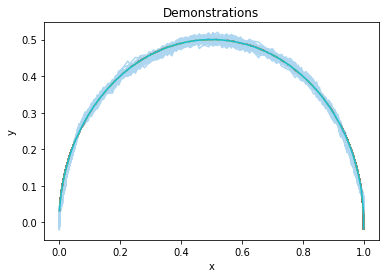

In [12]:
grl = GRL(env, noise=0.005)
demonstrations, XStore_steps, AStore_steps = grl.get_demonstrations(Ndemo=100, Kp=-100, Kd=-3)
grl.test_demonstrations(demonstrations, Nsamp=5, render=False)
# demonstrations['states'][0][:10], demonstrations['actions'][0][:10]

In [13]:
total_rewards = []
step_idx = 0
done_episodes = 0
DEMO_BATCH = 256
BSIZE = 256 # batch size

batch_episodes = 0
batch_states, batch_actions, batch_qvals = deque([], BSIZE), deque([], BSIZE), deque([], BSIZE)
net_rewards = deque([], 100)
env_rewards = deque([], 100)
loss_rwd = 0.

while done_episodes < 300000:
    states, actions, rewards, done = agent_net.generate_session(env, BSIZE)
    
    # Store samples in batch
    batch_states.extend(states)
    batch_actions.extend(actions)
    batch_qvals.extend(grl.calc_qvals(rewards))
    env_reward = np.sum(rewards)
    env_rewards.extend([env_reward])
    
    if len(batch_actions) < BSIZE:
        continue
    
    batch_episodes += 1
        
    # Get reward from reward_net
    x = torch.cat((float32_preprocessor(states), float32_preprocessor(actions).view(-1,1)), dim=1).to(device)
    net_reward = reward_net(x)
    net_rewards.extend([np.sum(net_reward.cpu().detach().numpy())])
         
    done_episodes += 1

    mean_env_rewards = float(np.mean(env_rewards))
    mean_net_rewards = float(np.mean(net_rewards))

    writer.add_scalar('Episodic Reward', env_reward, done_episodes)
    writer.add_scalar('mean_env_reward', mean_env_rewards, done_episodes)
    writer.add_scalar('mean_net_reward', mean_net_rewards, done_episodes)
    writer.add_scalar('loss_reward_net', loss_rwd, done_episodes)        

    print(f'{done_episodes}: reward: {env_reward:6.2f}, mean_env_reward: {mean_env_rewards:6.2f}, mean_net_reward: {mean_net_rewards:6.2f}, reward function loss: {loss_rwd:6.4f}')

    ## Tensorboard logging 
    if done_episodes%1000==0 or mean_env_rewards>=100:
        fig = reward_net.visualize_net(agent_net, Npoints=20)
        writer.add_figure('Reward Net', fig, global_step=done_episodes/100)
        
        test_reward, test_fig = agent_net.test_agent(env,device)
        writer.add_scalar('test_reward', test_reward, done_episodes)
        writer.add_figure('Agent traj', test_fig, global_step=done_episodes/100)
        torch.save(agent_net.state_dict(), 'pointspace_policy_net_origin.mod')
        torch.save(reward_net.state_dict(), 'pointspace_reward_net_origin.mod')

    if mean_env_rewards >= 100:
        print(f'Solved in {step_idx} steps and {done_episodes} episodes!')
        torch.save(agent_net.state_dict(), 'pointspace_policy_net_origin.mod')
        torch.save(reward_net.state_dict(), 'pointspace_reward_net_origin.mod')
#         break

    states_v = torch.FloatTensor(batch_states)
    batch_actions_t = torch.LongTensor(batch_actions)
    batch_qvals_v = torch.FloatTensor(batch_qvals)
  
    Total_steps_demo = len(AStore_steps)

    # reward function learning
    for rf_i in range(1):
        # ToDo: Sample from initial steps
        selected = np.random.choice(Total_steps_demo, DEMO_BATCH)
        demo_states = np.take(XStore_steps, selected, axis=0)
        demo_actions = np.take(AStore_steps, selected, axis=0)
        
        demo_batch_states = torch.FloatTensor(demo_states)
        demo_batch_actions = torch.FloatTensor(demo_actions)
        
        D_demo = torch.cat([demo_batch_states, demo_batch_actions.view(-1, 1)], dim=-1).to(device)
        D_samp = torch.cat([states_v, batch_actions_t.float().view(-1, 1)], dim=-1).to(device)
        D_samp = torch.cat([D_demo, D_samp])
                
        # dummy importance weights - fix later
        z = torch.ones((D_samp.shape[0], 1)).to(device)

        # objective
        D_demo_out = reward_net(D_demo)
        D_samp_out_net = reward_net(D_samp)
        D_samp_out = z * torch.exp(D_samp_out_net)
        
        loss_rwd = -torch.mean(D_demo_out) + torch.log(torch.mean(D_samp_out))
        optimizer_reward.zero_grad()
        loss_rwd.backward()
        optimizer_reward.step()
    
    # agent
    optimizer_agent.zero_grad()
    logits_v = agent_net(states_v.to(device))
    log_prob_v = torch.log_softmax(logits_v.cpu(), dim=1) # p(a|s)
    
    # batch_qvals_v = E(s)
    # REINFORCE
    log_prob_actions_v = batch_qvals_v * log_prob_v[range(len(batch_states)), batch_actions_t] #q(s,a)=p(a|s)E(s)
    loss_v = -log_prob_actions_v.mean()
    writer.add_scalar('loss_agent_net', loss_v, done_episodes) 
    
    loss_v.backward()
    optimizer_agent.step()

    batch_episodes = 0

env.close()
writer.close()

1: reward: 100.00, mean_env_reward:  96.33, mean_net_reward: -53.29, reward function loss: 0.0000
2: reward: 100.00, mean_env_reward:  97.25, mean_net_reward: -50.53, reward function loss: -0.3724
3: reward:  92.00, mean_env_reward:  96.20, mean_net_reward: -56.50, reward function loss: -0.3562
4: reward: 100.00, mean_env_reward:  96.83, mean_net_reward: -52.99, reward function loss: -0.3600
5: reward: 100.00, mean_env_reward:  97.29, mean_net_reward: -51.77, reward function loss: -0.3509
6: reward: 100.00, mean_env_reward:  97.62, mean_net_reward: -49.72, reward function loss: -0.3668
7: reward: 100.00, mean_env_reward:  97.89, mean_net_reward: -48.90, reward function loss: -0.3618
8: reward: 100.00, mean_env_reward:  98.10, mean_net_reward: -48.73, reward function loss: -0.3474
9: reward:  98.00, mean_env_reward:  98.09, mean_net_reward: -49.68, reward function loss: -0.3511
10: reward: 100.00, mean_env_reward:  98.25, mean_net_reward: -50.13, reward function loss: -0.3603
11: reward

85: reward:  99.00, mean_env_reward:  98.84, mean_net_reward: -53.86, reward function loss: -0.3870
86: reward: 100.00, mean_env_reward:  98.85, mean_net_reward: -53.92, reward function loss: -0.3756
87: reward: 100.00, mean_env_reward:  98.87, mean_net_reward: -53.86, reward function loss: -0.3796
88: reward:  94.00, mean_env_reward:  98.81, mean_net_reward: -53.80, reward function loss: -0.3695
89: reward: 100.00, mean_env_reward:  98.82, mean_net_reward: -53.73, reward function loss: -0.3740
90: reward:  86.00, mean_env_reward:  98.68, mean_net_reward: -53.99, reward function loss: -0.3725
91: reward: 100.00, mean_env_reward:  98.70, mean_net_reward: -54.06, reward function loss: -0.4110
92: reward:  88.00, mean_env_reward:  98.59, mean_net_reward: -54.25, reward function loss: -0.4106
93: reward: 100.00, mean_env_reward:  98.60, mean_net_reward: -54.19, reward function loss: -0.4121
94: reward: 100.00, mean_env_reward:  98.61, mean_net_reward: -54.07, reward function loss: -0.4047


169: reward: 100.00, mean_env_reward:  97.39, mean_net_reward: -54.30, reward function loss: -0.3957
170: reward: 100.00, mean_env_reward:  97.39, mean_net_reward: -54.30, reward function loss: -0.3812
171: reward: 100.00, mean_env_reward:  97.39, mean_net_reward: -54.45, reward function loss: -0.3589
172: reward: 100.00, mean_env_reward:  97.39, mean_net_reward: -54.52, reward function loss: -0.3765
173: reward: 100.00, mean_env_reward:  97.39, mean_net_reward: -54.53, reward function loss: -0.3880
174: reward: 100.00, mean_env_reward:  97.39, mean_net_reward: -54.47, reward function loss: -0.4012
175: reward:  97.00, mean_env_reward:  97.36, mean_net_reward: -54.63, reward function loss: -0.3968
176: reward:  99.00, mean_env_reward:  97.54, mean_net_reward: -54.42, reward function loss: -0.4009
177: reward: 100.00, mean_env_reward:  97.54, mean_net_reward: -54.55, reward function loss: -0.3830
178: reward: 100.00, mean_env_reward:  97.54, mean_net_reward: -54.29, reward function loss

253: reward: 100.00, mean_env_reward:  99.17, mean_net_reward: -54.86, reward function loss: -0.3716
254: reward: 100.00, mean_env_reward:  99.17, mean_net_reward: -54.99, reward function loss: -0.3515
255: reward:  96.00, mean_env_reward:  99.13, mean_net_reward: -55.00, reward function loss: -0.4120
256: reward: 100.00, mean_env_reward:  99.13, mean_net_reward: -55.01, reward function loss: -0.3866
257: reward:  74.00, mean_env_reward:  99.23, mean_net_reward: -54.99, reward function loss: -0.3865
258: reward:  93.00, mean_env_reward:  99.16, mean_net_reward: -55.03, reward function loss: -0.4049
259: reward: 100.00, mean_env_reward:  99.16, mean_net_reward: -55.17, reward function loss: -0.4124
260: reward: 100.00, mean_env_reward:  99.19, mean_net_reward: -55.29, reward function loss: -0.4040
261: reward: 100.00, mean_env_reward:  99.25, mean_net_reward: -55.15, reward function loss: -0.3860
262: reward: 100.00, mean_env_reward:  99.26, mean_net_reward: -55.06, reward function loss

337: reward: 100.00, mean_env_reward:  98.27, mean_net_reward: -57.66, reward function loss: -0.4230
338: reward: 100.00, mean_env_reward:  98.27, mean_net_reward: -57.78, reward function loss: -0.4156
339: reward:  81.00, mean_env_reward:  98.08, mean_net_reward: -57.95, reward function loss: -0.3953
340: reward:  60.00, mean_env_reward:  97.69, mean_net_reward: -57.90, reward function loss: -0.4109
341: reward: 100.00, mean_env_reward:  97.69, mean_net_reward: -57.80, reward function loss: -0.3851
342: reward: 100.00, mean_env_reward:  97.69, mean_net_reward: -57.66, reward function loss: -0.3804
343: reward: 100.00, mean_env_reward:  97.71, mean_net_reward: -57.46, reward function loss: -0.3865
344: reward:  93.00, mean_env_reward:  97.64, mean_net_reward: -57.48, reward function loss: -0.3845
345: reward: 100.00, mean_env_reward:  97.67, mean_net_reward: -57.67, reward function loss: -0.3999
346: reward:  81.00, mean_env_reward:  97.48, mean_net_reward: -58.02, reward function loss

421: reward:  91.00, mean_env_reward:  98.12, mean_net_reward: -56.79, reward function loss: -0.4098
422: reward: 100.00, mean_env_reward:  98.12, mean_net_reward: -56.87, reward function loss: -0.4352
423: reward: 100.00, mean_env_reward:  98.12, mean_net_reward: -56.86, reward function loss: -0.4362
424: reward: 100.00, mean_env_reward:  98.12, mean_net_reward: -56.94, reward function loss: -0.4273
425: reward: 100.00, mean_env_reward:  98.17, mean_net_reward: -56.93, reward function loss: -0.3816
426: reward: 100.00, mean_env_reward:  98.24, mean_net_reward: -56.89, reward function loss: -0.4032
427: reward: 100.00, mean_env_reward:  98.24, mean_net_reward: -57.04, reward function loss: -0.4082
428: reward: 100.00, mean_env_reward:  98.24, mean_net_reward: -57.02, reward function loss: -0.3911
429: reward: 100.00, mean_env_reward:  98.24, mean_net_reward: -56.92, reward function loss: -0.4112
430: reward: 100.00, mean_env_reward:  98.24, mean_net_reward: -56.80, reward function loss

505: reward: 100.00, mean_env_reward:  97.73, mean_net_reward: -60.20, reward function loss: -0.4066
506: reward: 100.00, mean_env_reward:  97.73, mean_net_reward: -60.18, reward function loss: -0.4121
507: reward: 100.00, mean_env_reward:  97.73, mean_net_reward: -60.40, reward function loss: -0.4200
508: reward: 100.00, mean_env_reward:  97.73, mean_net_reward: -60.69, reward function loss: -0.4347
509: reward: 100.00, mean_env_reward:  97.73, mean_net_reward: -60.88, reward function loss: -0.4310
510: reward:  93.00, mean_env_reward:  97.66, mean_net_reward: -61.10, reward function loss: -0.4145
511: reward:  95.00, mean_env_reward:  97.61, mean_net_reward: -61.12, reward function loss: -0.4425
512: reward:  87.00, mean_env_reward:  97.52, mean_net_reward: -61.30, reward function loss: -0.4434
513: reward: 100.00, mean_env_reward:  97.52, mean_net_reward: -61.27, reward function loss: -0.4477
514: reward: 100.00, mean_env_reward:  97.52, mean_net_reward: -61.35, reward function loss

589: reward: 100.00, mean_env_reward:  97.27, mean_net_reward: -64.21, reward function loss: -0.3854
590: reward: 100.00, mean_env_reward:  97.27, mean_net_reward: -64.35, reward function loss: -0.3745
591: reward: 100.00, mean_env_reward:  97.27, mean_net_reward: -64.04, reward function loss: -0.3998
592: reward: 100.00, mean_env_reward:  97.27, mean_net_reward: -63.99, reward function loss: -0.3834
593: reward: 100.00, mean_env_reward:  97.27, mean_net_reward: -64.21, reward function loss: -0.4044
594: reward: 100.00, mean_env_reward:  97.27, mean_net_reward: -64.47, reward function loss: -0.4146
595: reward: 100.00, mean_env_reward:  97.27, mean_net_reward: -64.40, reward function loss: -0.4252
596: reward:  75.00, mean_env_reward:  97.41, mean_net_reward: -64.18, reward function loss: -0.3933
597: reward: 100.00, mean_env_reward:  97.65, mean_net_reward: -64.24, reward function loss: -0.3721
598: reward: 100.00, mean_env_reward:  97.68, mean_net_reward: -64.17, reward function loss

673: reward: 100.00, mean_env_reward:  97.66, mean_net_reward: -60.53, reward function loss: -0.4075
674: reward:  95.00, mean_env_reward:  97.61, mean_net_reward: -60.61, reward function loss: -0.3856
675: reward: 100.00, mean_env_reward:  97.61, mean_net_reward: -60.36, reward function loss: -0.4000
676: reward: 100.00, mean_env_reward:  97.61, mean_net_reward: -60.33, reward function loss: -0.3942
677: reward:  94.00, mean_env_reward:  97.63, mean_net_reward: -60.27, reward function loss: -0.4307
678: reward:  95.00, mean_env_reward:  97.58, mean_net_reward: -60.50, reward function loss: -0.4129
679: reward:  95.00, mean_env_reward:  97.53, mean_net_reward: -60.78, reward function loss: -0.3983
680: reward:  76.00, mean_env_reward:  97.29, mean_net_reward: -60.70, reward function loss: -0.4320
681: reward:  96.00, mean_env_reward:  97.25, mean_net_reward: -60.70, reward function loss: -0.4443
682: reward: 100.00, mean_env_reward:  97.30, mean_net_reward: -60.40, reward function loss

757: reward:  98.00, mean_env_reward:  94.64, mean_net_reward: -62.75, reward function loss: -0.4084
758: reward: 100.00, mean_env_reward:  94.93, mean_net_reward: -62.93, reward function loss: -0.4017
759: reward: 100.00, mean_env_reward:  94.98, mean_net_reward: -63.00, reward function loss: -0.4178
760: reward: 100.00, mean_env_reward:  94.98, mean_net_reward: -62.98, reward function loss: -0.4144
761: reward: 100.00, mean_env_reward:  95.07, mean_net_reward: -62.91, reward function loss: -0.4073
762: reward: 100.00, mean_env_reward:  95.09, mean_net_reward: -62.71, reward function loss: -0.4259
763: reward: 100.00, mean_env_reward:  95.09, mean_net_reward: -62.82, reward function loss: -0.4181
764: reward:  99.00, mean_env_reward:  95.08, mean_net_reward: -62.83, reward function loss: -0.4112
765: reward: 100.00, mean_env_reward:  95.08, mean_net_reward: -63.00, reward function loss: -0.4175
766: reward: 100.00, mean_env_reward:  95.12, mean_net_reward: -62.78, reward function loss

841: reward: 100.00, mean_env_reward:  97.23, mean_net_reward: -63.14, reward function loss: -0.4007
842: reward: 100.00, mean_env_reward:  97.23, mean_net_reward: -63.44, reward function loss: -0.4096
843: reward: 100.00, mean_env_reward:  97.23, mean_net_reward: -63.59, reward function loss: -0.4272
844: reward: 100.00, mean_env_reward:  97.23, mean_net_reward: -63.66, reward function loss: -0.4476
845: reward: 100.00, mean_env_reward:  97.23, mean_net_reward: -63.50, reward function loss: -0.4523
846: reward: 100.00, mean_env_reward:  97.47, mean_net_reward: -63.23, reward function loss: -0.4293
847: reward: 100.00, mean_env_reward:  97.47, mean_net_reward: -63.02, reward function loss: -0.4238
848: reward: 100.00, mean_env_reward:  97.76, mean_net_reward: -62.73, reward function loss: -0.3856
849: reward: 100.00, mean_env_reward:  97.80, mean_net_reward: -62.62, reward function loss: -0.3800
850: reward: 100.00, mean_env_reward:  97.80, mean_net_reward: -62.58, reward function loss

925: reward: 100.00, mean_env_reward:  99.35, mean_net_reward: -63.46, reward function loss: -0.3927
926: reward:  98.00, mean_env_reward:  99.33, mean_net_reward: -63.42, reward function loss: -0.4029
927: reward:  93.00, mean_env_reward:  99.26, mean_net_reward: -63.44, reward function loss: -0.4116
928: reward: 100.00, mean_env_reward:  99.26, mean_net_reward: -63.14, reward function loss: -0.4365
929: reward: 100.00, mean_env_reward:  99.26, mean_net_reward: -63.18, reward function loss: -0.4058
930: reward: 100.00, mean_env_reward:  99.27, mean_net_reward: -63.25, reward function loss: -0.4289
931: reward: 100.00, mean_env_reward:  99.27, mean_net_reward: -63.25, reward function loss: -0.4403
932: reward: 100.00, mean_env_reward:  99.27, mean_net_reward: -63.27, reward function loss: -0.4504
933: reward:  77.00, mean_env_reward:  99.04, mean_net_reward: -63.62, reward function loss: -0.4366
934: reward:  87.00, mean_env_reward:  98.91, mean_net_reward: -63.63, reward function loss

1007: reward: 100.00, mean_env_reward:  97.49, mean_net_reward: -68.05, reward function loss: -0.4784
1008: reward: 100.00, mean_env_reward:  97.49, mean_net_reward: -67.98, reward function loss: -0.4259
1009: reward: 100.00, mean_env_reward:  97.49, mean_net_reward: -67.92, reward function loss: -0.4059
1010: reward: 100.00, mean_env_reward:  97.49, mean_net_reward: -67.85, reward function loss: -0.3711
1011: reward: 100.00, mean_env_reward:  97.49, mean_net_reward: -67.81, reward function loss: -0.4171
1012: reward: 100.00, mean_env_reward:  97.49, mean_net_reward: -67.96, reward function loss: -0.4405
1013: reward: 100.00, mean_env_reward:  97.49, mean_net_reward: -68.02, reward function loss: -0.4548
1014: reward: 100.00, mean_env_reward:  97.49, mean_net_reward: -68.00, reward function loss: -0.4670
1015: reward: 100.00, mean_env_reward:  97.49, mean_net_reward: -67.83, reward function loss: -0.4656
1016: reward: 100.00, mean_env_reward:  97.49, mean_net_reward: -67.69, reward fun

1088: reward: 100.00, mean_env_reward:  98.41, mean_net_reward: -67.01, reward function loss: -0.4513
1089: reward: 100.00, mean_env_reward:  98.41, mean_net_reward: -66.79, reward function loss: -0.4418
1090: reward: 100.00, mean_env_reward:  98.53, mean_net_reward: -66.49, reward function loss: -0.4348
1091: reward: 100.00, mean_env_reward:  98.53, mean_net_reward: -66.53, reward function loss: -0.4279
1092: reward: 100.00, mean_env_reward:  98.58, mean_net_reward: -66.29, reward function loss: -0.4282
1093: reward: 100.00, mean_env_reward:  98.59, mean_net_reward: -66.05, reward function loss: -0.4007
1094: reward: 100.00, mean_env_reward:  98.59, mean_net_reward: -65.65, reward function loss: -0.4250
1095: reward:  95.00, mean_env_reward:  98.54, mean_net_reward: -65.62, reward function loss: -0.3771
1096: reward: 100.00, mean_env_reward:  98.54, mean_net_reward: -65.49, reward function loss: -0.4077
1097: reward: 100.00, mean_env_reward:  98.74, mean_net_reward: -65.56, reward fun

1169: reward: 100.00, mean_env_reward:  98.57, mean_net_reward: -62.79, reward function loss: -0.4099
1170: reward: 100.00, mean_env_reward:  98.57, mean_net_reward: -62.67, reward function loss: -0.4099
1171: reward: 100.00, mean_env_reward:  98.57, mean_net_reward: -62.60, reward function loss: -0.4282
1172: reward:  97.00, mean_env_reward:  98.54, mean_net_reward: -62.50, reward function loss: -0.4252
1173: reward: 100.00, mean_env_reward:  98.54, mean_net_reward: -62.54, reward function loss: -0.4210
1174: reward: 100.00, mean_env_reward:  98.54, mean_net_reward: -62.62, reward function loss: -0.4147
1175: reward:  84.00, mean_env_reward:  98.38, mean_net_reward: -63.02, reward function loss: -0.4108
1176: reward: 100.00, mean_env_reward:  98.38, mean_net_reward: -63.01, reward function loss: -0.4381
1177: reward: 100.00, mean_env_reward:  98.38, mean_net_reward: -62.93, reward function loss: -0.4098
1178: reward: 100.00, mean_env_reward:  98.38, mean_net_reward: -62.94, reward fun

1250: reward: 100.00, mean_env_reward:  98.62, mean_net_reward: -62.76, reward function loss: -0.3993
1251: reward: 100.00, mean_env_reward:  98.62, mean_net_reward: -62.55, reward function loss: -0.4130
1252: reward: 100.00, mean_env_reward:  98.62, mean_net_reward: -62.65, reward function loss: -0.4257
1253: reward: 100.00, mean_env_reward:  98.62, mean_net_reward: -62.73, reward function loss: -0.4208
1254: reward: 100.00, mean_env_reward:  98.65, mean_net_reward: -62.78, reward function loss: -0.4328
1255: reward:  99.00, mean_env_reward:  98.64, mean_net_reward: -62.95, reward function loss: -0.4339
1256: reward:  87.00, mean_env_reward:  98.67, mean_net_reward: -62.78, reward function loss: -0.4156
1257: reward: 100.00, mean_env_reward:  98.67, mean_net_reward: -62.67, reward function loss: -0.3874
1258: reward:  95.00, mean_env_reward:  98.62, mean_net_reward: -62.68, reward function loss: -0.3680
1259: reward: 100.00, mean_env_reward:  98.62, mean_net_reward: -62.38, reward fun

1331: reward:  99.00, mean_env_reward:  98.24, mean_net_reward: -62.36, reward function loss: -0.4220
1332: reward:  97.00, mean_env_reward:  98.21, mean_net_reward: -62.36, reward function loss: -0.3711
1333: reward: 100.00, mean_env_reward:  98.21, mean_net_reward: -62.10, reward function loss: -0.4236
1334: reward: 100.00, mean_env_reward:  98.23, mean_net_reward: -61.91, reward function loss: -0.4168
1335: reward: 100.00, mean_env_reward:  98.23, mean_net_reward: -61.83, reward function loss: -0.3843
1336: reward:  71.00, mean_env_reward:  98.01, mean_net_reward: -62.13, reward function loss: -0.3824
1337: reward: 100.00, mean_env_reward:  98.02, mean_net_reward: -62.00, reward function loss: -0.4514
1338: reward: 100.00, mean_env_reward:  98.02, mean_net_reward: -62.07, reward function loss: -0.4303
1339: reward: 100.00, mean_env_reward:  98.02, mean_net_reward: -62.05, reward function loss: -0.4053
1340: reward: 100.00, mean_env_reward:  98.02, mean_net_reward: -62.06, reward fun

1412: reward:  98.00, mean_env_reward:  98.03, mean_net_reward: -60.60, reward function loss: -0.4238
1413: reward: 100.00, mean_env_reward:  98.03, mean_net_reward: -60.69, reward function loss: -0.3820
1414: reward: 100.00, mean_env_reward:  98.03, mean_net_reward: -60.55, reward function loss: -0.3917
1415: reward:  97.00, mean_env_reward:  98.00, mean_net_reward: -60.44, reward function loss: -0.3808
1416: reward: 100.00, mean_env_reward:  98.00, mean_net_reward: -60.74, reward function loss: -0.3807
1417: reward:  99.00, mean_env_reward:  98.17, mean_net_reward: -60.76, reward function loss: -0.3964
1418: reward: 100.00, mean_env_reward:  98.17, mean_net_reward: -60.53, reward function loss: -0.4557
1419: reward:  95.00, mean_env_reward:  98.12, mean_net_reward: -60.26, reward function loss: -0.3965
1420: reward: 100.00, mean_env_reward:  98.12, mean_net_reward: -60.10, reward function loss: -0.3904
1421: reward: 100.00, mean_env_reward:  98.30, mean_net_reward: -60.42, reward fun

1493: reward:  91.00, mean_env_reward:  98.52, mean_net_reward: -62.38, reward function loss: -0.4094
1494: reward: 100.00, mean_env_reward:  98.52, mean_net_reward: -62.56, reward function loss: -0.3969
1495: reward: 100.00, mean_env_reward:  98.55, mean_net_reward: -62.67, reward function loss: -0.4278
1496: reward: 100.00, mean_env_reward:  98.55, mean_net_reward: -62.59, reward function loss: -0.4181
1497: reward:  97.00, mean_env_reward:  98.53, mean_net_reward: -62.52, reward function loss: -0.4160
1498: reward: 100.00, mean_env_reward:  98.53, mean_net_reward: -62.71, reward function loss: -0.4150
1499: reward:  89.00, mean_env_reward:  98.42, mean_net_reward: -62.84, reward function loss: -0.4223
1500: reward:  81.00, mean_env_reward:  98.27, mean_net_reward: -62.87, reward function loss: -0.4534
1501: reward: 100.00, mean_env_reward:  98.39, mean_net_reward: -62.66, reward function loss: -0.4181
1502: reward: 100.00, mean_env_reward:  98.39, mean_net_reward: -62.73, reward fun

1574: reward:  98.00, mean_env_reward:  96.74, mean_net_reward: -65.07, reward function loss: -0.4704
1575: reward:  92.00, mean_env_reward:  96.68, mean_net_reward: -65.35, reward function loss: -0.4573
1576: reward: 100.00, mean_env_reward:  96.68, mean_net_reward: -65.51, reward function loss: -0.4732
1577: reward:  97.00, mean_env_reward:  96.67, mean_net_reward: -65.76, reward function loss: -0.4636
1578: reward: 100.00, mean_env_reward:  96.67, mean_net_reward: -65.94, reward function loss: -0.4538
1579: reward: 100.00, mean_env_reward:  96.70, mean_net_reward: -65.77, reward function loss: -0.4703
1580: reward:  99.00, mean_env_reward:  96.71, mean_net_reward: -65.92, reward function loss: -0.4239
1581: reward:  88.00, mean_env_reward:  96.61, mean_net_reward: -66.08, reward function loss: -0.4481
1582: reward: 100.00, mean_env_reward:  96.61, mean_net_reward: -65.83, reward function loss: -0.4613
1583: reward:  79.00, mean_env_reward:  96.45, mean_net_reward: -66.03, reward fun

1655: reward: 100.00, mean_env_reward:  96.00, mean_net_reward: -66.26, reward function loss: -0.4028
1656: reward: 100.00, mean_env_reward:  96.00, mean_net_reward: -66.22, reward function loss: -0.4466
1657: reward:  89.00, mean_env_reward:  95.89, mean_net_reward: -66.13, reward function loss: -0.4444
1658: reward: 100.00, mean_env_reward:  95.89, mean_net_reward: -66.04, reward function loss: -0.4385
1659: reward:  99.00, mean_env_reward:  95.88, mean_net_reward: -66.19, reward function loss: -0.4291
1660: reward:  98.00, mean_env_reward:  95.86, mean_net_reward: -66.32, reward function loss: -0.4169
1661: reward:  99.00, mean_env_reward:  95.85, mean_net_reward: -66.25, reward function loss: -0.4089
1662: reward:  97.00, mean_env_reward:  95.84, mean_net_reward: -66.07, reward function loss: -0.4299
1663: reward:  97.00, mean_env_reward:  95.81, mean_net_reward: -65.78, reward function loss: -0.4182
1664: reward:  99.00, mean_env_reward:  96.36, mean_net_reward: -65.53, reward fun

1736: reward:  96.00, mean_env_reward:  96.66, mean_net_reward: -66.30, reward function loss: -0.4253
1737: reward:  88.00, mean_env_reward:  96.55, mean_net_reward: -66.24, reward function loss: -0.4388
1738: reward: 100.00, mean_env_reward:  96.61, mean_net_reward: -66.53, reward function loss: -0.4209
1739: reward: 100.00, mean_env_reward:  96.61, mean_net_reward: -66.57, reward function loss: -0.4423
1740: reward:  95.00, mean_env_reward:  96.58, mean_net_reward: -66.60, reward function loss: -0.4836
1741: reward:  99.00, mean_env_reward:  96.59, mean_net_reward: -66.67, reward function loss: -0.4832
1742: reward:  97.00, mean_env_reward:  96.56, mean_net_reward: -66.59, reward function loss: -0.4438
1743: reward:  75.00, mean_env_reward:  96.31, mean_net_reward: -66.72, reward function loss: -0.4283
1744: reward: 100.00, mean_env_reward:  96.31, mean_net_reward: -66.76, reward function loss: -0.4135
1745: reward:  98.00, mean_env_reward:  96.41, mean_net_reward: -66.42, reward fun

1817: reward: 100.00, mean_env_reward:  96.54, mean_net_reward: -63.61, reward function loss: -0.4349
1818: reward:  85.00, mean_env_reward:  96.42, mean_net_reward: -63.82, reward function loss: -0.4170
1819: reward: 100.00, mean_env_reward:  96.42, mean_net_reward: -63.88, reward function loss: -0.4385
1820: reward: 100.00, mean_env_reward:  96.44, mean_net_reward: -63.77, reward function loss: -0.4583
1821: reward:  96.00, mean_env_reward:  96.45, mean_net_reward: -64.06, reward function loss: -0.4512
1822: reward:  96.00, mean_env_reward:  96.46, mean_net_reward: -63.66, reward function loss: -0.4537
1823: reward:  98.00, mean_env_reward:  96.47, mean_net_reward: -63.55, reward function loss: -0.4318
1824: reward:  96.00, mean_env_reward:  96.43, mean_net_reward: -63.34, reward function loss: -0.4025
1825: reward: 100.00, mean_env_reward:  96.46, mean_net_reward: -63.38, reward function loss: -0.3987
1826: reward: 100.00, mean_env_reward:  96.46, mean_net_reward: -63.36, reward fun

1898: reward:  98.00, mean_env_reward:  97.43, mean_net_reward: -62.75, reward function loss: -0.4274
1899: reward: 100.00, mean_env_reward:  97.43, mean_net_reward: -63.14, reward function loss: -0.4239
1900: reward:  91.00, mean_env_reward:  97.34, mean_net_reward: -63.41, reward function loss: -0.4409
1901: reward: 100.00, mean_env_reward:  97.35, mean_net_reward: -63.60, reward function loss: -0.4584
1902: reward:  97.00, mean_env_reward:  97.34, mean_net_reward: -63.45, reward function loss: -0.4889
1903: reward: 100.00, mean_env_reward:  97.42, mean_net_reward: -63.38, reward function loss: -0.4527
1904: reward: 100.00, mean_env_reward:  97.42, mean_net_reward: -63.30, reward function loss: -0.4259
1905: reward:  98.00, mean_env_reward:  97.40, mean_net_reward: -63.05, reward function loss: -0.4400
1906: reward: 100.00, mean_env_reward:  97.40, mean_net_reward: -63.13, reward function loss: -0.4237
1907: reward: 100.00, mean_env_reward:  97.40, mean_net_reward: -63.46, reward fun

1979: reward: 100.00, mean_env_reward:  96.24, mean_net_reward: -68.12, reward function loss: -0.4045
1980: reward: 100.00, mean_env_reward:  96.25, mean_net_reward: -67.97, reward function loss: -0.4553
1981: reward: 100.00, mean_env_reward:  96.25, mean_net_reward: -67.96, reward function loss: -0.4160
1982: reward: 100.00, mean_env_reward:  96.25, mean_net_reward: -67.97, reward function loss: -0.4295
1983: reward:  99.00, mean_env_reward:  96.28, mean_net_reward: -67.82, reward function loss: -0.3949
1984: reward: 100.00, mean_env_reward:  96.29, mean_net_reward: -67.77, reward function loss: -0.3880
1985: reward:  99.00, mean_env_reward:  96.28, mean_net_reward: -68.04, reward function loss: -0.4011
1986: reward:  95.00, mean_env_reward:  96.23, mean_net_reward: -68.09, reward function loss: -0.4069
1987: reward: 100.00, mean_env_reward:  96.23, mean_net_reward: -67.96, reward function loss: -0.4338
1988: reward: 100.00, mean_env_reward:  96.23, mean_net_reward: -67.84, reward fun

2061: reward:  99.00, mean_env_reward:  97.51, mean_net_reward: -64.91, reward function loss: -0.4330
2062: reward: 100.00, mean_env_reward:  97.51, mean_net_reward: -65.00, reward function loss: -0.4262
2063: reward:  61.00, mean_env_reward:  97.21, mean_net_reward: -65.02, reward function loss: -0.4092
2064: reward: 100.00, mean_env_reward:  97.21, mean_net_reward: -64.96, reward function loss: -0.4310
2065: reward: 100.00, mean_env_reward:  97.21, mean_net_reward: -64.69, reward function loss: -0.4638
2066: reward:  98.00, mean_env_reward:  97.19, mean_net_reward: -64.65, reward function loss: -0.4413
2067: reward:  98.00, mean_env_reward:  97.39, mean_net_reward: -64.39, reward function loss: -0.4181
2068: reward: 100.00, mean_env_reward:  97.39, mean_net_reward: -64.59, reward function loss: -0.4103
2069: reward: 100.00, mean_env_reward:  97.39, mean_net_reward: -64.55, reward function loss: -0.4620
2070: reward:  92.00, mean_env_reward:  97.31, mean_net_reward: -64.73, reward fun

2144: reward: 100.00, mean_env_reward:  96.20, mean_net_reward: -66.69, reward function loss: -0.4235
2145: reward: 100.00, mean_env_reward:  96.20, mean_net_reward: -66.86, reward function loss: -0.4452
2146: reward: 100.00, mean_env_reward:  96.24, mean_net_reward: -67.07, reward function loss: -0.4232
2147: reward:  97.00, mean_env_reward:  96.21, mean_net_reward: -66.87, reward function loss: -0.4534
2148: reward: 100.00, mean_env_reward:  96.22, mean_net_reward: -67.07, reward function loss: -0.4487
2149: reward:  99.00, mean_env_reward:  96.21, mean_net_reward: -67.19, reward function loss: -0.4316
2150: reward:  91.00, mean_env_reward:  96.32, mean_net_reward: -66.85, reward function loss: -0.4415
2151: reward: 100.00, mean_env_reward:  96.32, mean_net_reward: -66.81, reward function loss: -0.4373
2152: reward: 100.00, mean_env_reward:  96.32, mean_net_reward: -66.97, reward function loss: -0.4143
2153: reward:  99.00, mean_env_reward:  96.33, mean_net_reward: -67.01, reward fun

2225: reward:  97.00, mean_env_reward:  96.12, mean_net_reward: -65.18, reward function loss: -0.4222
2226: reward:  97.00, mean_env_reward:  96.09, mean_net_reward: -65.43, reward function loss: -0.4140
2227: reward:  97.00, mean_env_reward:  96.10, mean_net_reward: -65.39, reward function loss: -0.4165
2228: reward: 100.00, mean_env_reward:  96.10, mean_net_reward: -65.71, reward function loss: -0.4017
2229: reward:  98.00, mean_env_reward:  96.26, mean_net_reward: -65.60, reward function loss: -0.4176
2230: reward: 100.00, mean_env_reward:  96.26, mean_net_reward: -65.79, reward function loss: -0.4366
2231: reward: 100.00, mean_env_reward:  96.30, mean_net_reward: -65.48, reward function loss: -0.4795
2232: reward: 100.00, mean_env_reward:  96.30, mean_net_reward: -65.66, reward function loss: -0.4257
2233: reward:  97.00, mean_env_reward:  96.27, mean_net_reward: -65.51, reward function loss: -0.4191
2234: reward: 100.00, mean_env_reward:  96.27, mean_net_reward: -65.12, reward fun

2306: reward: 100.00, mean_env_reward:  97.41, mean_net_reward: -64.05, reward function loss: -0.4153
2307: reward: 100.00, mean_env_reward:  97.63, mean_net_reward: -63.76, reward function loss: -0.3977
2308: reward: 100.00, mean_env_reward:  97.63, mean_net_reward: -63.66, reward function loss: -0.3837
2309: reward: 100.00, mean_env_reward:  97.74, mean_net_reward: -63.70, reward function loss: -0.4129
2310: reward: 100.00, mean_env_reward:  97.76, mean_net_reward: -63.84, reward function loss: -0.4650
2311: reward: 100.00, mean_env_reward:  97.90, mean_net_reward: -63.78, reward function loss: -0.4528
2312: reward: 100.00, mean_env_reward:  97.90, mean_net_reward: -63.77, reward function loss: -0.4448
2313: reward: 100.00, mean_env_reward:  97.90, mean_net_reward: -63.95, reward function loss: -0.4370
2314: reward:  97.00, mean_env_reward:  98.08, mean_net_reward: -63.62, reward function loss: -0.4401
2315: reward: 100.00, mean_env_reward:  98.08, mean_net_reward: -63.73, reward fun

2387: reward:  92.00, mean_env_reward:  96.17, mean_net_reward: -64.91, reward function loss: -0.3991
2388: reward:  90.00, mean_env_reward:  96.07, mean_net_reward: -65.00, reward function loss: -0.4102
2389: reward: 100.00, mean_env_reward:  96.07, mean_net_reward: -65.23, reward function loss: -0.4188
2390: reward: 100.00, mean_env_reward:  96.12, mean_net_reward: -64.71, reward function loss: -0.4546
2391: reward: 100.00, mean_env_reward:  96.12, mean_net_reward: -64.51, reward function loss: -0.4533
2392: reward: 100.00, mean_env_reward:  96.12, mean_net_reward: -64.40, reward function loss: -0.4051
2393: reward: 100.00, mean_env_reward:  96.12, mean_net_reward: -64.62, reward function loss: -0.3831
2394: reward: 100.00, mean_env_reward:  96.23, mean_net_reward: -64.69, reward function loss: -0.4118
2395: reward:  97.00, mean_env_reward:  96.20, mean_net_reward: -64.96, reward function loss: -0.4424
2396: reward: 100.00, mean_env_reward:  96.20, mean_net_reward: -64.99, reward fun

2470: reward:  97.00, mean_env_reward:  97.40, mean_net_reward: -64.43, reward function loss: -0.4244
2471: reward: 100.00, mean_env_reward:  97.40, mean_net_reward: -64.47, reward function loss: -0.4028
2472: reward: 100.00, mean_env_reward:  97.60, mean_net_reward: -64.14, reward function loss: -0.4409
2473: reward:  98.00, mean_env_reward:  97.58, mean_net_reward: -64.20, reward function loss: -0.4564
2474: reward: 100.00, mean_env_reward:  97.58, mean_net_reward: -63.89, reward function loss: -0.4390
2475: reward:  85.00, mean_env_reward:  97.52, mean_net_reward: -64.19, reward function loss: -0.4192
2476: reward:  87.00, mean_env_reward:  97.60, mean_net_reward: -64.31, reward function loss: -0.4445
2477: reward: 100.00, mean_env_reward:  97.60, mean_net_reward: -64.30, reward function loss: -0.4584
2478: reward: 100.00, mean_env_reward:  97.60, mean_net_reward: -64.12, reward function loss: -0.4601
2479: reward:  76.00, mean_env_reward:  97.36, mean_net_reward: -64.34, reward fun

2551: reward:  96.00, mean_env_reward:  97.54, mean_net_reward: -65.16, reward function loss: -0.4335
2552: reward: 100.00, mean_env_reward:  97.54, mean_net_reward: -65.42, reward function loss: -0.4146
2553: reward: 100.00, mean_env_reward:  97.54, mean_net_reward: -65.60, reward function loss: -0.4420
2554: reward:  98.00, mean_env_reward:  97.52, mean_net_reward: -65.62, reward function loss: -0.4398
2555: reward: 100.00, mean_env_reward:  97.58, mean_net_reward: -66.00, reward function loss: -0.4275
2556: reward:  99.00, mean_env_reward:  97.57, mean_net_reward: -65.98, reward function loss: -0.4570
2557: reward: 100.00, mean_env_reward:  97.57, mean_net_reward: -66.03, reward function loss: -0.4395
2558: reward: 100.00, mean_env_reward:  97.62, mean_net_reward: -66.00, reward function loss: -0.4224
2559: reward: 100.00, mean_env_reward:  97.82, mean_net_reward: -65.74, reward function loss: -0.4197
2560: reward: 100.00, mean_env_reward:  97.82, mean_net_reward: -65.62, reward fun

2632: reward: 100.00, mean_env_reward:  99.26, mean_net_reward: -63.33, reward function loss: -0.4525
2633: reward: 100.00, mean_env_reward:  99.26, mean_net_reward: -63.33, reward function loss: -0.4503
2634: reward: 100.00, mean_env_reward:  99.26, mean_net_reward: -63.39, reward function loss: -0.4540
2635: reward: 100.00, mean_env_reward:  99.26, mean_net_reward: -63.19, reward function loss: -0.4311
2636: reward: 100.00, mean_env_reward:  99.26, mean_net_reward: -63.36, reward function loss: -0.3941
2637: reward: 100.00, mean_env_reward:  99.26, mean_net_reward: -63.37, reward function loss: -0.4168
2638: reward: 100.00, mean_env_reward:  99.26, mean_net_reward: -63.16, reward function loss: -0.3919
2639: reward: 100.00, mean_env_reward:  99.26, mean_net_reward: -63.14, reward function loss: -0.3960
2640: reward: 100.00, mean_env_reward:  99.26, mean_net_reward: -63.03, reward function loss: -0.4215
2641: reward:  99.00, mean_env_reward:  99.25, mean_net_reward: -63.07, reward fun

2713: reward: 100.00, mean_env_reward:  99.13, mean_net_reward: -62.78, reward function loss: -0.4181
2714: reward: 100.00, mean_env_reward:  99.13, mean_net_reward: -62.86, reward function loss: -0.3952
2715: reward: 100.00, mean_env_reward:  99.13, mean_net_reward: -62.70, reward function loss: -0.3920
2716: reward:  70.00, mean_env_reward:  98.83, mean_net_reward: -63.01, reward function loss: -0.4297
2717: reward:  90.00, mean_env_reward:  98.78, mean_net_reward: -63.02, reward function loss: -0.4592
2718: reward: 100.00, mean_env_reward:  98.78, mean_net_reward: -63.00, reward function loss: -0.4570
2719: reward: 100.00, mean_env_reward:  98.78, mean_net_reward: -62.82, reward function loss: -0.4480
2720: reward: 100.00, mean_env_reward:  98.78, mean_net_reward: -62.87, reward function loss: -0.4253
2721: reward: 100.00, mean_env_reward:  98.78, mean_net_reward: -63.19, reward function loss: -0.4407
2722: reward: 100.00, mean_env_reward:  98.78, mean_net_reward: -63.48, reward fun

2794: reward: 100.00, mean_env_reward:  97.66, mean_net_reward: -64.46, reward function loss: -0.4418
2795: reward: 100.00, mean_env_reward:  97.66, mean_net_reward: -64.47, reward function loss: -0.4282
2796: reward: 100.00, mean_env_reward:  97.66, mean_net_reward: -64.49, reward function loss: -0.4468
2797: reward: 100.00, mean_env_reward:  97.73, mean_net_reward: -64.51, reward function loss: -0.4446
2798: reward: 100.00, mean_env_reward:  97.73, mean_net_reward: -64.75, reward function loss: -0.4294
2799: reward:  86.00, mean_env_reward:  97.59, mean_net_reward: -64.90, reward function loss: -0.4360
2800: reward: 100.00, mean_env_reward:  97.59, mean_net_reward: -65.12, reward function loss: -0.4348
2801: reward:  90.00, mean_env_reward:  97.49, mean_net_reward: -65.26, reward function loss: -0.4669
2802: reward: 100.00, mean_env_reward:  97.49, mean_net_reward: -65.33, reward function loss: -0.4820
2803: reward: 100.00, mean_env_reward:  97.49, mean_net_reward: -65.53, reward fun

2875: reward: 100.00, mean_env_reward:  97.47, mean_net_reward: -65.32, reward function loss: -0.4038
2876: reward: 100.00, mean_env_reward:  97.47, mean_net_reward: -65.46, reward function loss: -0.4354
2877: reward: 100.00, mean_env_reward:  97.47, mean_net_reward: -65.61, reward function loss: -0.4305
2878: reward:  97.00, mean_env_reward:  97.44, mean_net_reward: -65.35, reward function loss: -0.4669
2879: reward: 100.00, mean_env_reward:  97.44, mean_net_reward: -65.16, reward function loss: -0.4212
2880: reward: 100.00, mean_env_reward:  97.44, mean_net_reward: -65.34, reward function loss: -0.3964
2881: reward: 100.00, mean_env_reward:  97.44, mean_net_reward: -65.45, reward function loss: -0.4201
2882: reward:  97.00, mean_env_reward:  97.44, mean_net_reward: -65.32, reward function loss: -0.4556
2883: reward:  98.00, mean_env_reward:  97.42, mean_net_reward: -65.24, reward function loss: -0.4592
2884: reward: 100.00, mean_env_reward:  97.66, mean_net_reward: -65.13, reward fun

2956: reward: 100.00, mean_env_reward:  97.95, mean_net_reward: -63.61, reward function loss: -0.4492
2957: reward: 100.00, mean_env_reward:  97.95, mean_net_reward: -63.45, reward function loss: -0.4276
2958: reward: 100.00, mean_env_reward:  97.95, mean_net_reward: -63.31, reward function loss: -0.3926
2959: reward:  99.00, mean_env_reward:  97.94, mean_net_reward: -63.53, reward function loss: -0.4091
2960: reward: 100.00, mean_env_reward:  98.00, mean_net_reward: -63.40, reward function loss: -0.4308
2961: reward:  96.00, mean_env_reward:  97.96, mean_net_reward: -63.66, reward function loss: -0.4341
2962: reward:  97.00, mean_env_reward:  97.93, mean_net_reward: -64.12, reward function loss: -0.4501
2963: reward: 100.00, mean_env_reward:  97.93, mean_net_reward: -64.07, reward function loss: -0.4634
2964: reward: 100.00, mean_env_reward:  97.93, mean_net_reward: -63.93, reward function loss: -0.4571
2965: reward: 100.00, mean_env_reward:  97.93, mean_net_reward: -63.73, reward fun

3037: reward:  89.00, mean_env_reward:  98.74, mean_net_reward: -63.48, reward function loss: -0.4434
3038: reward: 100.00, mean_env_reward:  98.75, mean_net_reward: -63.54, reward function loss: -0.4290
3039: reward: 100.00, mean_env_reward:  98.77, mean_net_reward: -63.28, reward function loss: -0.4580
3040: reward: 100.00, mean_env_reward:  98.77, mean_net_reward: -63.60, reward function loss: -0.3958
3041: reward: 100.00, mean_env_reward:  98.77, mean_net_reward: -63.71, reward function loss: -0.4074
3042: reward: 100.00, mean_env_reward:  98.77, mean_net_reward: -63.69, reward function loss: -0.4140
3043: reward: 100.00, mean_env_reward:  98.77, mean_net_reward: -63.82, reward function loss: -0.4120
3044: reward: 100.00, mean_env_reward:  98.78, mean_net_reward: -63.66, reward function loss: -0.4403
3045: reward: 100.00, mean_env_reward:  98.78, mean_net_reward: -63.80, reward function loss: -0.4347
3046: reward: 100.00, mean_env_reward:  98.88, mean_net_reward: -63.72, reward fun

3118: reward: 100.00, mean_env_reward:  97.41, mean_net_reward: -65.07, reward function loss: -0.4440
3119: reward: 100.00, mean_env_reward:  97.41, mean_net_reward: -64.96, reward function loss: -0.4487
3120: reward: 100.00, mean_env_reward:  97.41, mean_net_reward: -65.05, reward function loss: -0.4296
3121: reward: 100.00, mean_env_reward:  97.41, mean_net_reward: -65.02, reward function loss: -0.4197
3122: reward: 100.00, mean_env_reward:  97.41, mean_net_reward: -65.38, reward function loss: -0.4291
3123: reward: 100.00, mean_env_reward:  97.47, mean_net_reward: -65.49, reward function loss: -0.4313
3124: reward:  82.00, mean_env_reward:  97.29, mean_net_reward: -65.55, reward function loss: -0.4595
3125: reward:  97.00, mean_env_reward:  97.52, mean_net_reward: -65.23, reward function loss: -0.4732
3126: reward: 100.00, mean_env_reward:  97.52, mean_net_reward: -65.14, reward function loss: -0.4610
3127: reward: 100.00, mean_env_reward:  97.52, mean_net_reward: -65.21, reward fun

3199: reward: 100.00, mean_env_reward:  97.53, mean_net_reward: -65.79, reward function loss: -0.4364
3200: reward: 100.00, mean_env_reward:  97.54, mean_net_reward: -65.92, reward function loss: -0.4373
3201: reward: 100.00, mean_env_reward:  97.54, mean_net_reward: -65.85, reward function loss: -0.4522
3202: reward:  99.00, mean_env_reward:  97.80, mean_net_reward: -65.73, reward function loss: -0.4562
3203: reward: 100.00, mean_env_reward:  97.80, mean_net_reward: -65.75, reward function loss: -0.4529
3204: reward:  82.00, mean_env_reward:  97.62, mean_net_reward: -65.92, reward function loss: -0.4366
3205: reward:  96.00, mean_env_reward:  97.58, mean_net_reward: -66.24, reward function loss: -0.4742
3206: reward: 100.00, mean_env_reward:  97.61, mean_net_reward: -66.07, reward function loss: -0.4526
3207: reward: 100.00, mean_env_reward:  97.69, mean_net_reward: -65.83, reward function loss: -0.4622
3208: reward: 100.00, mean_env_reward:  98.33, mean_net_reward: -65.88, reward fun

3280: reward: 100.00, mean_env_reward:  98.51, mean_net_reward: -66.86, reward function loss: -0.4290
3281: reward: 100.00, mean_env_reward:  98.51, mean_net_reward: -67.05, reward function loss: -0.4449
3282: reward: 100.00, mean_env_reward:  98.51, mean_net_reward: -67.28, reward function loss: -0.4457
3283: reward: 100.00, mean_env_reward:  98.51, mean_net_reward: -67.28, reward function loss: -0.4676
3284: reward: 100.00, mean_env_reward:  98.51, mean_net_reward: -67.47, reward function loss: -0.4391
3285: reward: 100.00, mean_env_reward:  98.51, mean_net_reward: -67.49, reward function loss: -0.4389
3286: reward: 100.00, mean_env_reward:  98.64, mean_net_reward: -67.24, reward function loss: -0.4478
3287: reward: 100.00, mean_env_reward:  98.64, mean_net_reward: -67.06, reward function loss: -0.4397
3288: reward: 100.00, mean_env_reward:  98.64, mean_net_reward: -67.02, reward function loss: -0.4489
3289: reward: 100.00, mean_env_reward:  98.64, mean_net_reward: -67.06, reward fun

3361: reward: 100.00, mean_env_reward:  98.99, mean_net_reward: -66.48, reward function loss: -0.4504
3362: reward: 100.00, mean_env_reward:  98.99, mean_net_reward: -66.48, reward function loss: -0.4251
3363: reward: 100.00, mean_env_reward:  98.99, mean_net_reward: -66.56, reward function loss: -0.4155
3364: reward: 100.00, mean_env_reward:  98.99, mean_net_reward: -66.59, reward function loss: -0.4126
3365: reward:  98.00, mean_env_reward:  98.97, mean_net_reward: -66.69, reward function loss: -0.4202
3366: reward: 100.00, mean_env_reward:  98.97, mean_net_reward: -66.52, reward function loss: -0.4282
3367: reward:  99.00, mean_env_reward:  98.96, mean_net_reward: -66.42, reward function loss: -0.4095
3368: reward: 100.00, mean_env_reward:  98.96, mean_net_reward: -66.40, reward function loss: -0.4193
3369: reward: 100.00, mean_env_reward:  98.96, mean_net_reward: -66.46, reward function loss: -0.4197
3370: reward: 100.00, mean_env_reward:  98.96, mean_net_reward: -66.80, reward fun

3444: reward: 100.00, mean_env_reward:  98.88, mean_net_reward: -66.45, reward function loss: -0.4549
3445: reward: 100.00, mean_env_reward:  98.88, mean_net_reward: -66.60, reward function loss: -0.4485
3446: reward:  98.00, mean_env_reward:  98.86, mean_net_reward: -66.78, reward function loss: -0.4351
3447: reward: 100.00, mean_env_reward:  98.86, mean_net_reward: -66.69, reward function loss: -0.4478
3448: reward: 100.00, mean_env_reward:  98.86, mean_net_reward: -66.56, reward function loss: -0.4879
3449: reward:  92.00, mean_env_reward:  98.78, mean_net_reward: -66.58, reward function loss: -0.4157
3450: reward:  95.00, mean_env_reward:  98.73, mean_net_reward: -66.76, reward function loss: -0.4222
3451: reward: 100.00, mean_env_reward:  98.73, mean_net_reward: -67.02, reward function loss: -0.4894
3452: reward: 100.00, mean_env_reward:  98.84, mean_net_reward: -67.18, reward function loss: -0.4808
3453: reward:  96.00, mean_env_reward:  98.80, mean_net_reward: -67.08, reward fun

3525: reward:  99.00, mean_env_reward:  98.02, mean_net_reward: -68.82, reward function loss: -0.4632
3526: reward: 100.00, mean_env_reward:  98.04, mean_net_reward: -68.65, reward function loss: -0.4485
3527: reward: 100.00, mean_env_reward:  98.07, mean_net_reward: -68.80, reward function loss: -0.4398
3528: reward: 100.00, mean_env_reward:  98.07, mean_net_reward: -68.89, reward function loss: -0.4445
3529: reward: 100.00, mean_env_reward:  98.07, mean_net_reward: -68.91, reward function loss: -0.4350
3530: reward: 100.00, mean_env_reward:  98.07, mean_net_reward: -68.93, reward function loss: -0.4462
3531: reward: 100.00, mean_env_reward:  98.07, mean_net_reward: -68.88, reward function loss: -0.4399
3532: reward: 100.00, mean_env_reward:  98.07, mean_net_reward: -68.98, reward function loss: -0.4215
3533: reward: 100.00, mean_env_reward:  98.07, mean_net_reward: -69.10, reward function loss: -0.4349
3534: reward: 100.00, mean_env_reward:  98.20, mean_net_reward: -69.24, reward fun

3606: reward: 100.00, mean_env_reward:  98.55, mean_net_reward: -68.51, reward function loss: -0.4161
3607: reward: 100.00, mean_env_reward:  98.55, mean_net_reward: -68.70, reward function loss: -0.4259
3608: reward: 100.00, mean_env_reward:  98.57, mean_net_reward: -68.61, reward function loss: -0.4618
3609: reward: 100.00, mean_env_reward:  98.57, mean_net_reward: -68.78, reward function loss: -0.4278
3610: reward: 100.00, mean_env_reward:  98.77, mean_net_reward: -68.91, reward function loss: -0.4336
3611: reward: 100.00, mean_env_reward:  98.77, mean_net_reward: -68.71, reward function loss: -0.4476
3612: reward: 100.00, mean_env_reward:  98.77, mean_net_reward: -68.38, reward function loss: -0.4677
3613: reward: 100.00, mean_env_reward:  98.77, mean_net_reward: -68.35, reward function loss: -0.4262
3614: reward: 100.00, mean_env_reward:  98.77, mean_net_reward: -68.16, reward function loss: -0.4213
3615: reward:  97.00, mean_env_reward:  98.76, mean_net_reward: -68.37, reward fun

3687: reward:  90.00, mean_env_reward:  98.24, mean_net_reward: -65.19, reward function loss: -0.4628
3688: reward:  98.00, mean_env_reward:  98.22, mean_net_reward: -65.22, reward function loss: -0.4831
3689: reward: 100.00, mean_env_reward:  98.22, mean_net_reward: -65.60, reward function loss: -0.4973
3690: reward:  98.00, mean_env_reward:  98.20, mean_net_reward: -65.69, reward function loss: -0.5120
3691: reward: 100.00, mean_env_reward:  98.20, mean_net_reward: -65.72, reward function loss: -0.5129
3692: reward:  99.00, mean_env_reward:  98.19, mean_net_reward: -65.64, reward function loss: -0.5154
3693: reward: 100.00, mean_env_reward:  98.19, mean_net_reward: -65.77, reward function loss: -0.4769
3694: reward: 100.00, mean_env_reward:  98.19, mean_net_reward: -65.77, reward function loss: -0.4622
3695: reward:  62.00, mean_env_reward:  97.81, mean_net_reward: -65.94, reward function loss: -0.4387
3696: reward:  98.00, mean_env_reward:  97.79, mean_net_reward: -65.64, reward fun

3768: reward:  85.00, mean_env_reward:  91.07, mean_net_reward: -77.03, reward function loss: -0.4861
3769: reward:  88.00, mean_env_reward:  90.95, mean_net_reward: -77.37, reward function loss: -0.4727
3770: reward: 100.00, mean_env_reward:  91.00, mean_net_reward: -77.48, reward function loss: -0.4974
3771: reward:  99.00, mean_env_reward:  90.99, mean_net_reward: -77.42, reward function loss: -0.5018
3772: reward: 100.00, mean_env_reward:  91.25, mean_net_reward: -77.11, reward function loss: -0.4781
3773: reward: 100.00, mean_env_reward:  91.25, mean_net_reward: -77.00, reward function loss: -0.4678
3774: reward: 100.00, mean_env_reward:  91.25, mean_net_reward: -76.78, reward function loss: -0.4628
3775: reward:  93.00, mean_env_reward:  91.18, mean_net_reward: -77.33, reward function loss: -0.4466
3776: reward:  83.00, mean_env_reward:  91.01, mean_net_reward: -77.82, reward function loss: -0.4472
3777: reward: 100.00, mean_env_reward:  91.01, mean_net_reward: -78.29, reward fun

3849: reward: 100.00, mean_env_reward:  95.00, mean_net_reward: -71.76, reward function loss: -0.4071
3850: reward: 100.00, mean_env_reward:  95.04, mean_net_reward: -71.87, reward function loss: -0.4591
3851: reward: 100.00, mean_env_reward:  95.04, mean_net_reward: -71.56, reward function loss: -0.4644
3852: reward: 100.00, mean_env_reward:  95.43, mean_net_reward: -71.33, reward function loss: -0.4390
3853: reward: 100.00, mean_env_reward:  95.80, mean_net_reward: -70.77, reward function loss: -0.4328
3854: reward: 100.00, mean_env_reward:  95.83, mean_net_reward: -70.54, reward function loss: -0.3946
3855: reward: 100.00, mean_env_reward:  95.83, mean_net_reward: -70.57, reward function loss: -0.3920
3856: reward: 100.00, mean_env_reward:  96.13, mean_net_reward: -70.31, reward function loss: -0.4464
3857: reward: 100.00, mean_env_reward:  96.17, mean_net_reward: -70.22, reward function loss: -0.4635
3858: reward:  64.00, mean_env_reward:  95.84, mean_net_reward: -70.67, reward fun

3930: reward: 100.00, mean_env_reward:  98.35, mean_net_reward: -69.45, reward function loss: -0.4383
3931: reward: 100.00, mean_env_reward:  98.35, mean_net_reward: -69.56, reward function loss: -0.4830
3932: reward: 100.00, mean_env_reward:  98.35, mean_net_reward: -69.86, reward function loss: -0.4796
3933: reward: 100.00, mean_env_reward:  98.35, mean_net_reward: -69.92, reward function loss: -0.5214
3934: reward: 100.00, mean_env_reward:  98.35, mean_net_reward: -69.84, reward function loss: -0.4854
3935: reward: 100.00, mean_env_reward:  98.35, mean_net_reward: -69.48, reward function loss: -0.4640
3936: reward: 100.00, mean_env_reward:  98.35, mean_net_reward: -69.15, reward function loss: -0.4312
3937: reward: 100.00, mean_env_reward:  98.35, mean_net_reward: -69.21, reward function loss: -0.4161
3938: reward: 100.00, mean_env_reward:  98.36, mean_net_reward: -69.56, reward function loss: -0.4010
3939: reward: 100.00, mean_env_reward:  98.36, mean_net_reward: -69.47, reward fun

4013: reward: 100.00, mean_env_reward:  96.42, mean_net_reward: -70.81, reward function loss: -0.4494
4014: reward: 100.00, mean_env_reward:  96.42, mean_net_reward: -70.47, reward function loss: -0.4767
4015: reward: 100.00, mean_env_reward:  96.42, mean_net_reward: -70.48, reward function loss: -0.4536
4016: reward:  82.00, mean_env_reward:  96.24, mean_net_reward: -70.84, reward function loss: -0.4205
4017: reward: 100.00, mean_env_reward:  96.45, mean_net_reward: -70.70, reward function loss: -0.4462
4018: reward: 100.00, mean_env_reward:  96.50, mean_net_reward: -70.68, reward function loss: -0.4680
4019: reward:  97.00, mean_env_reward:  96.60, mean_net_reward: -70.44, reward function loss: -0.4883
4020: reward:  99.00, mean_env_reward:  96.59, mean_net_reward: -70.30, reward function loss: -0.4583
4021: reward: 100.00, mean_env_reward:  96.59, mean_net_reward: -70.01, reward function loss: -0.4315
4022: reward: 100.00, mean_env_reward:  96.59, mean_net_reward: -70.15, reward fun

4094: reward:  99.00, mean_env_reward:  97.92, mean_net_reward: -66.71, reward function loss: -0.4413
4095: reward: 100.00, mean_env_reward:  97.93, mean_net_reward: -66.55, reward function loss: -0.4638
4096: reward: 100.00, mean_env_reward:  97.93, mean_net_reward: -66.92, reward function loss: -0.4389
4097: reward: 100.00, mean_env_reward:  97.93, mean_net_reward: -67.39, reward function loss: -0.4447
4098: reward: 100.00, mean_env_reward:  98.02, mean_net_reward: -67.16, reward function loss: -0.4509
4099: reward: 100.00, mean_env_reward:  98.02, mean_net_reward: -67.19, reward function loss: -0.4615
4100: reward: 100.00, mean_env_reward:  98.02, mean_net_reward: -67.40, reward function loss: -0.4322
4101: reward: 100.00, mean_env_reward:  98.02, mean_net_reward: -67.46, reward function loss: -0.4356
4102: reward:  77.00, mean_env_reward:  97.88, mean_net_reward: -67.37, reward function loss: -0.4745
4103: reward: 100.00, mean_env_reward:  97.88, mean_net_reward: -67.34, reward fun

4175: reward: 100.00, mean_env_reward:  98.25, mean_net_reward: -69.24, reward function loss: -0.4736
4176: reward:  55.00, mean_env_reward:  97.80, mean_net_reward: -69.42, reward function loss: -0.4421
4177: reward: 100.00, mean_env_reward:  97.80, mean_net_reward: -69.73, reward function loss: -0.4543
4178: reward: 100.00, mean_env_reward:  97.80, mean_net_reward: -69.67, reward function loss: -0.4638
4179: reward: 100.00, mean_env_reward:  97.80, mean_net_reward: -69.71, reward function loss: -0.4393
4180: reward: 100.00, mean_env_reward:  97.80, mean_net_reward: -69.57, reward function loss: -0.4377
4181: reward: 100.00, mean_env_reward:  97.80, mean_net_reward: -69.47, reward function loss: -0.4358
4182: reward: 100.00, mean_env_reward:  97.80, mean_net_reward: -69.81, reward function loss: -0.4273
4183: reward: 100.00, mean_env_reward:  97.80, mean_net_reward: -69.67, reward function loss: -0.4633
4184: reward: 100.00, mean_env_reward:  97.80, mean_net_reward: -69.56, reward fun

4256: reward: 100.00, mean_env_reward:  98.31, mean_net_reward: -67.43, reward function loss: -0.4395
4257: reward: 100.00, mean_env_reward:  98.31, mean_net_reward: -67.42, reward function loss: -0.4485
4258: reward: 100.00, mean_env_reward:  98.31, mean_net_reward: -67.24, reward function loss: -0.4070
4259: reward:  99.00, mean_env_reward:  98.30, mean_net_reward: -67.27, reward function loss: -0.3938
4260: reward: 100.00, mean_env_reward:  98.30, mean_net_reward: -67.04, reward function loss: -0.4274
4261: reward: 100.00, mean_env_reward:  98.30, mean_net_reward: -67.15, reward function loss: -0.4047
4262: reward: 100.00, mean_env_reward:  98.30, mean_net_reward: -67.27, reward function loss: -0.4371
4263: reward: 100.00, mean_env_reward:  98.30, mean_net_reward: -67.36, reward function loss: -0.4650
4264: reward:  99.00, mean_env_reward:  98.29, mean_net_reward: -67.37, reward function loss: -0.4743
4265: reward: 100.00, mean_env_reward:  98.29, mean_net_reward: -67.16, reward fun

4339: reward: 100.00, mean_env_reward:  99.07, mean_net_reward: -66.56, reward function loss: -0.4786
4340: reward:  48.00, mean_env_reward:  98.55, mean_net_reward: -66.68, reward function loss: -0.4630
4341: reward: 100.00, mean_env_reward:  98.57, mean_net_reward: -66.49, reward function loss: -0.4859
4342: reward: 100.00, mean_env_reward:  98.60, mean_net_reward: -66.31, reward function loss: -0.4639
4343: reward: 100.00, mean_env_reward:  98.60, mean_net_reward: -66.14, reward function loss: -0.4350
4344: reward:  99.00, mean_env_reward:  98.59, mean_net_reward: -66.04, reward function loss: -0.4130
4345: reward:  89.00, mean_env_reward:  98.48, mean_net_reward: -66.34, reward function loss: -0.4030
4346: reward: 100.00, mean_env_reward:  98.48, mean_net_reward: -66.54, reward function loss: -0.3874
4347: reward: 100.00, mean_env_reward:  98.50, mean_net_reward: -66.50, reward function loss: -0.4363
4348: reward: 100.00, mean_env_reward:  98.50, mean_net_reward: -66.46, reward fun

4420: reward:  98.00, mean_env_reward:  97.35, mean_net_reward: -65.14, reward function loss: -0.4193
4421: reward:  98.00, mean_env_reward:  97.33, mean_net_reward: -65.08, reward function loss: -0.4199
4422: reward:  97.00, mean_env_reward:  97.30, mean_net_reward: -65.05, reward function loss: -0.4086
4423: reward: 100.00, mean_env_reward:  97.32, mean_net_reward: -64.84, reward function loss: -0.4272
4424: reward:  99.00, mean_env_reward:  97.31, mean_net_reward: -64.88, reward function loss: -0.4037
4425: reward: 100.00, mean_env_reward:  97.32, mean_net_reward: -64.99, reward function loss: -0.3980
4426: reward: 100.00, mean_env_reward:  97.32, mean_net_reward: -64.98, reward function loss: -0.4457
4427: reward: 100.00, mean_env_reward:  97.32, mean_net_reward: -65.16, reward function loss: -0.4248
4428: reward: 100.00, mean_env_reward:  97.32, mean_net_reward: -65.02, reward function loss: -0.4190
4429: reward: 100.00, mean_env_reward:  97.33, mean_net_reward: -64.87, reward fun

4501: reward: 100.00, mean_env_reward:  97.49, mean_net_reward: -67.11, reward function loss: -0.4711
4502: reward: 100.00, mean_env_reward:  97.49, mean_net_reward: -67.34, reward function loss: -0.4547
4503: reward: 100.00, mean_env_reward:  97.49, mean_net_reward: -67.12, reward function loss: -0.4655
4504: reward: 100.00, mean_env_reward:  97.49, mean_net_reward: -67.02, reward function loss: -0.4102
4505: reward: 100.00, mean_env_reward:  97.57, mean_net_reward: -66.98, reward function loss: -0.4445
4506: reward: 100.00, mean_env_reward:  97.57, mean_net_reward: -66.94, reward function loss: -0.4415
4507: reward:  87.00, mean_env_reward:  97.49, mean_net_reward: -67.05, reward function loss: -0.4343
4508: reward: 100.00, mean_env_reward:  97.53, mean_net_reward: -67.03, reward function loss: -0.4354
4509: reward: 100.00, mean_env_reward:  97.53, mean_net_reward: -66.90, reward function loss: -0.4551
4510: reward: 100.00, mean_env_reward:  97.53, mean_net_reward: -66.99, reward fun

4582: reward:  99.00, mean_env_reward:  97.79, mean_net_reward: -66.43, reward function loss: -0.4096
4583: reward: 100.00, mean_env_reward:  97.79, mean_net_reward: -66.17, reward function loss: -0.4480
4584: reward: 100.00, mean_env_reward:  97.79, mean_net_reward: -65.94, reward function loss: -0.4447
4585: reward: 100.00, mean_env_reward:  97.79, mean_net_reward: -66.05, reward function loss: -0.4109
4586: reward: 100.00, mean_env_reward:  97.97, mean_net_reward: -66.20, reward function loss: -0.4170
4587: reward: 100.00, mean_env_reward:  97.97, mean_net_reward: -66.23, reward function loss: -0.4490
4588: reward: 100.00, mean_env_reward:  97.97, mean_net_reward: -66.23, reward function loss: -0.4724
4589: reward: 100.00, mean_env_reward:  97.97, mean_net_reward: -66.21, reward function loss: -0.4838
4590: reward: 100.00, mean_env_reward:  97.97, mean_net_reward: -65.72, reward function loss: -0.4487
4591: reward: 100.00, mean_env_reward:  97.97, mean_net_reward: -65.70, reward fun

4663: reward: 100.00, mean_env_reward:  98.77, mean_net_reward: -66.14, reward function loss: -0.4404
4664: reward: 100.00, mean_env_reward:  98.77, mean_net_reward: -66.19, reward function loss: -0.4500
4665: reward: 100.00, mean_env_reward:  98.77, mean_net_reward: -66.15, reward function loss: -0.4316
4666: reward:  77.00, mean_env_reward:  98.55, mean_net_reward: -65.91, reward function loss: -0.4486
4667: reward: 100.00, mean_env_reward:  98.55, mean_net_reward: -65.70, reward function loss: -0.4187
4668: reward: 100.00, mean_env_reward:  98.55, mean_net_reward: -65.77, reward function loss: -0.4097
4669: reward:  69.00, mean_env_reward:  98.24, mean_net_reward: -65.69, reward function loss: -0.4090
4670: reward: 100.00, mean_env_reward:  98.24, mean_net_reward: -65.75, reward function loss: -0.4049
4671: reward: 100.00, mean_env_reward:  98.28, mean_net_reward: -65.72, reward function loss: -0.4255
4672: reward: 100.00, mean_env_reward:  98.28, mean_net_reward: -65.58, reward fun

4744: reward: 100.00, mean_env_reward:  98.19, mean_net_reward: -66.35, reward function loss: -0.4612
4745: reward: 100.00, mean_env_reward:  98.19, mean_net_reward: -66.15, reward function loss: -0.4591
4746: reward: 100.00, mean_env_reward:  98.19, mean_net_reward: -66.19, reward function loss: -0.4424
4747: reward: 100.00, mean_env_reward:  98.19, mean_net_reward: -66.79, reward function loss: -0.4369
4748: reward: 100.00, mean_env_reward:  98.19, mean_net_reward: -66.57, reward function loss: -0.4503
4749: reward:  97.00, mean_env_reward:  98.16, mean_net_reward: -66.76, reward function loss: -0.4180
4750: reward: 100.00, mean_env_reward:  98.21, mean_net_reward: -66.58, reward function loss: -0.4649
4751: reward: 100.00, mean_env_reward:  98.21, mean_net_reward: -66.50, reward function loss: -0.4748
4752: reward:  99.00, mean_env_reward:  98.20, mean_net_reward: -66.58, reward function loss: -0.4465
4753: reward: 100.00, mean_env_reward:  98.20, mean_net_reward: -66.48, reward fun

4825: reward: 100.00, mean_env_reward:  99.02, mean_net_reward: -67.15, reward function loss: -0.4562
4826: reward: 100.00, mean_env_reward:  99.02, mean_net_reward: -67.28, reward function loss: -0.4406
4827: reward:  82.00, mean_env_reward:  98.84, mean_net_reward: -67.53, reward function loss: -0.4219
4828: reward: 100.00, mean_env_reward:  98.84, mean_net_reward: -67.60, reward function loss: -0.4024
4829: reward:  97.00, mean_env_reward:  98.81, mean_net_reward: -67.38, reward function loss: -0.4023
4830: reward: 100.00, mean_env_reward:  98.81, mean_net_reward: -67.12, reward function loss: -0.4089
4831: reward: 100.00, mean_env_reward:  98.81, mean_net_reward: -67.04, reward function loss: -0.3874
4832: reward: 100.00, mean_env_reward:  98.85, mean_net_reward: -66.93, reward function loss: -0.4049
4833: reward:  95.00, mean_env_reward:  98.88, mean_net_reward: -66.85, reward function loss: -0.4308
4834: reward: 100.00, mean_env_reward:  98.88, mean_net_reward: -66.81, reward fun

4906: reward: 100.00, mean_env_reward:  98.85, mean_net_reward: -68.81, reward function loss: -0.4739
4907: reward:  88.00, mean_env_reward:  98.73, mean_net_reward: -68.94, reward function loss: -0.4479
4908: reward: 100.00, mean_env_reward:  98.73, mean_net_reward: -69.03, reward function loss: -0.4509
4909: reward: 100.00, mean_env_reward:  98.73, mean_net_reward: -69.29, reward function loss: -0.4751
4910: reward: 100.00, mean_env_reward:  98.79, mean_net_reward: -69.28, reward function loss: -0.4854
4911: reward: 100.00, mean_env_reward:  98.79, mean_net_reward: -69.34, reward function loss: -0.4706
4912: reward: 100.00, mean_env_reward:  98.79, mean_net_reward: -69.22, reward function loss: -0.4737
4913: reward: 100.00, mean_env_reward:  98.80, mean_net_reward: -69.27, reward function loss: -0.4429
4914: reward:  91.00, mean_env_reward:  98.71, mean_net_reward: -69.42, reward function loss: -0.4452
4915: reward:  92.00, mean_env_reward:  98.63, mean_net_reward: -69.68, reward fun

4987: reward: 100.00, mean_env_reward:  97.79, mean_net_reward: -71.18, reward function loss: -0.4657
4988: reward: 100.00, mean_env_reward:  97.81, mean_net_reward: -71.12, reward function loss: -0.5008
4989: reward: 100.00, mean_env_reward:  97.81, mean_net_reward: -71.07, reward function loss: -0.4580
4990: reward: 100.00, mean_env_reward:  97.81, mean_net_reward: -71.14, reward function loss: -0.4393
4991: reward: 100.00, mean_env_reward:  97.81, mean_net_reward: -71.05, reward function loss: -0.4392
4992: reward: 100.00, mean_env_reward:  97.81, mean_net_reward: -70.82, reward function loss: -0.4567
4993: reward:  96.00, mean_env_reward:  97.77, mean_net_reward: -70.93, reward function loss: -0.4182
4994: reward: 100.00, mean_env_reward:  97.77, mean_net_reward: -70.89, reward function loss: -0.4487
4995: reward:  98.00, mean_env_reward:  97.75, mean_net_reward: -70.88, reward function loss: -0.4665
4996: reward: 100.00, mean_env_reward:  97.75, mean_net_reward: -70.96, reward fun

5069: reward: 100.00, mean_env_reward:  97.55, mean_net_reward: -68.63, reward function loss: -0.4594
5070: reward:  98.00, mean_env_reward:  97.53, mean_net_reward: -68.56, reward function loss: -0.4191
5071: reward:  96.00, mean_env_reward:  97.53, mean_net_reward: -68.55, reward function loss: -0.4002
5072: reward: 100.00, mean_env_reward:  98.16, mean_net_reward: -68.39, reward function loss: -0.4110
5073: reward: 100.00, mean_env_reward:  98.55, mean_net_reward: -68.20, reward function loss: -0.4144
5074: reward:  97.00, mean_env_reward:  98.52, mean_net_reward: -68.15, reward function loss: -0.4416
5075: reward:  99.00, mean_env_reward:  98.51, mean_net_reward: -68.41, reward function loss: -0.4786
5076: reward:  85.00, mean_env_reward:  98.36, mean_net_reward: -68.01, reward function loss: -0.4753
5077: reward: 100.00, mean_env_reward:  98.38, mean_net_reward: -68.05, reward function loss: -0.4117
5078: reward: 100.00, mean_env_reward:  98.38, mean_net_reward: -68.31, reward fun

5150: reward:  75.00, mean_env_reward:  97.49, mean_net_reward: -71.69, reward function loss: -0.4550
5151: reward: 100.00, mean_env_reward:  97.53, mean_net_reward: -71.55, reward function loss: -0.4993
5152: reward: 100.00, mean_env_reward:  97.53, mean_net_reward: -71.53, reward function loss: -0.4934
5153: reward: 100.00, mean_env_reward:  97.55, mean_net_reward: -71.29, reward function loss: -0.4839
5154: reward: 100.00, mean_env_reward:  97.55, mean_net_reward: -71.93, reward function loss: -0.4194
5155: reward:  95.00, mean_env_reward:  97.51, mean_net_reward: -72.20, reward function loss: -0.4681
5156: reward: 100.00, mean_env_reward:  97.51, mean_net_reward: -72.47, reward function loss: -0.5080
5157: reward:  84.00, mean_env_reward:  97.38, mean_net_reward: -72.57, reward function loss: -0.5187
5158: reward: 100.00, mean_env_reward:  97.38, mean_net_reward: -72.78, reward function loss: -0.5247
5159: reward:  97.00, mean_env_reward:  97.35, mean_net_reward: -72.55, reward fun

5231: reward: 100.00, mean_env_reward:  96.95, mean_net_reward: -78.59, reward function loss: -0.5087
5232: reward: 100.00, mean_env_reward:  96.95, mean_net_reward: -78.06, reward function loss: -0.5249
5233: reward: 100.00, mean_env_reward:  96.95, mean_net_reward: -78.22, reward function loss: -0.4655
5234: reward: 100.00, mean_env_reward:  96.95, mean_net_reward: -78.26, reward function loss: -0.4326
5235: reward:  96.00, mean_env_reward:  96.94, mean_net_reward: -78.62, reward function loss: -0.4490
5236: reward: 100.00, mean_env_reward:  96.99, mean_net_reward: -79.01, reward function loss: -0.4931
5237: reward: 100.00, mean_env_reward:  97.02, mean_net_reward: -78.94, reward function loss: -0.4989
5238: reward:  94.00, mean_env_reward:  96.96, mean_net_reward: -78.95, reward function loss: -0.4956
5239: reward: 100.00, mean_env_reward:  96.96, mean_net_reward: -79.15, reward function loss: -0.5072
5240: reward: 100.00, mean_env_reward:  96.96, mean_net_reward: -79.45, reward fun

5312: reward: 100.00, mean_env_reward:  95.54, mean_net_reward: -82.09, reward function loss: -0.4793
5313: reward:  98.00, mean_env_reward:  95.52, mean_net_reward: -82.12, reward function loss: -0.5221
5314: reward: 100.00, mean_env_reward:  95.53, mean_net_reward: -82.09, reward function loss: -0.5180
5315: reward:  96.00, mean_env_reward:  95.49, mean_net_reward: -82.06, reward function loss: -0.5146
5316: reward: 100.00, mean_env_reward:  95.49, mean_net_reward: -81.83, reward function loss: -0.5250
5317: reward:  89.00, mean_env_reward:  95.38, mean_net_reward: -81.83, reward function loss: -0.4934
5318: reward: 100.00, mean_env_reward:  95.38, mean_net_reward: -81.88, reward function loss: -0.4961
5319: reward: 100.00, mean_env_reward:  95.38, mean_net_reward: -82.24, reward function loss: -0.4930
5320: reward: 100.00, mean_env_reward:  95.38, mean_net_reward: -82.36, reward function loss: -0.5068
5321: reward:  98.00, mean_env_reward:  95.36, mean_net_reward: -82.39, reward fun

5395: reward: 100.00, mean_env_reward:  98.03, mean_net_reward: -79.22, reward function loss: -0.5093
5396: reward:  98.00, mean_env_reward:  98.01, mean_net_reward: -79.08, reward function loss: -0.4801
5397: reward:  95.00, mean_env_reward:  98.35, mean_net_reward: -78.63, reward function loss: -0.4685
5398: reward:  86.00, mean_env_reward:  98.21, mean_net_reward: -78.68, reward function loss: -0.4240
5399: reward:  65.00, mean_env_reward:  97.86, mean_net_reward: -78.66, reward function loss: -0.4283
5400: reward: 100.00, mean_env_reward:  97.86, mean_net_reward: -78.93, reward function loss: -0.4548
5401: reward:  95.00, mean_env_reward:  97.87, mean_net_reward: -78.88, reward function loss: -0.5134
5402: reward:  98.00, mean_env_reward:  97.97, mean_net_reward: -78.91, reward function loss: -0.5224
5403: reward: 100.00, mean_env_reward:  97.97, mean_net_reward: -78.73, reward function loss: -0.5114
5404: reward: 100.00, mean_env_reward:  97.97, mean_net_reward: -78.69, reward fun

5476: reward: 100.00, mean_env_reward:  96.70, mean_net_reward: -80.26, reward function loss: -0.4935
5477: reward:  76.00, mean_env_reward:  96.46, mean_net_reward: -80.43, reward function loss: -0.4901
5478: reward: 100.00, mean_env_reward:  96.46, mean_net_reward: -80.50, reward function loss: -0.5006
5479: reward: 100.00, mean_env_reward:  96.46, mean_net_reward: -80.61, reward function loss: -0.4984
5480: reward: 100.00, mean_env_reward:  96.46, mean_net_reward: -80.48, reward function loss: -0.4989
5481: reward: 100.00, mean_env_reward:  96.46, mean_net_reward: -80.11, reward function loss: -0.4879
5482: reward: 100.00, mean_env_reward:  96.46, mean_net_reward: -80.26, reward function loss: -0.4185
5483: reward: 100.00, mean_env_reward:  96.46, mean_net_reward: -80.33, reward function loss: -0.4522
5484: reward: 100.00, mean_env_reward:  96.46, mean_net_reward: -80.26, reward function loss: -0.4957
5485: reward:  85.00, mean_env_reward:  96.31, mean_net_reward: -80.34, reward fun

5557: reward: 100.00, mean_env_reward:  96.40, mean_net_reward: -80.61, reward function loss: -0.5259
5558: reward: 100.00, mean_env_reward:  96.40, mean_net_reward: -80.48, reward function loss: -0.5012
5559: reward:  99.00, mean_env_reward:  96.39, mean_net_reward: -80.48, reward function loss: -0.4777
5560: reward: 100.00, mean_env_reward:  96.39, mean_net_reward: -80.66, reward function loss: -0.5011
5561: reward:  91.00, mean_env_reward:  96.30, mean_net_reward: -80.70, reward function loss: -0.5233
5562: reward: 100.00, mean_env_reward:  96.30, mean_net_reward: -80.45, reward function loss: -0.5183
5563: reward: 100.00, mean_env_reward:  96.30, mean_net_reward: -80.51, reward function loss: -0.4932
5564: reward:  96.00, mean_env_reward:  96.26, mean_net_reward: -80.92, reward function loss: -0.4902
5565: reward: 100.00, mean_env_reward:  96.26, mean_net_reward: -80.83, reward function loss: -0.5074
5566: reward: 100.00, mean_env_reward:  96.28, mean_net_reward: -80.76, reward fun

5638: reward: 100.00, mean_env_reward:  95.95, mean_net_reward: -82.47, reward function loss: -0.4245
5639: reward: 100.00, mean_env_reward:  95.97, mean_net_reward: -82.21, reward function loss: -0.4836
5640: reward:  97.00, mean_env_reward:  95.94, mean_net_reward: -81.95, reward function loss: -0.4374
5641: reward:  97.00, mean_env_reward:  95.91, mean_net_reward: -81.85, reward function loss: -0.4535
5642: reward: 100.00, mean_env_reward:  95.91, mean_net_reward: -81.50, reward function loss: -0.4607
5643: reward: 100.00, mean_env_reward:  95.91, mean_net_reward: -81.68, reward function loss: -0.4523
5644: reward: 100.00, mean_env_reward:  95.91, mean_net_reward: -81.78, reward function loss: -0.4352
5645: reward: 100.00, mean_env_reward:  95.91, mean_net_reward: -81.69, reward function loss: -0.4752
5646: reward: 100.00, mean_env_reward:  95.92, mean_net_reward: -81.53, reward function loss: -0.4739
5647: reward: 100.00, mean_env_reward:  95.92, mean_net_reward: -81.02, reward fun

5719: reward: 100.00, mean_env_reward:  98.02, mean_net_reward: -78.41, reward function loss: -0.4870
5720: reward:  83.00, mean_env_reward:  97.85, mean_net_reward: -78.36, reward function loss: -0.5115
5721: reward: 100.00, mean_env_reward:  97.85, mean_net_reward: -78.19, reward function loss: -0.5179
5722: reward: 100.00, mean_env_reward:  97.85, mean_net_reward: -78.18, reward function loss: -0.5058
5723: reward:  98.00, mean_env_reward:  97.83, mean_net_reward: -78.51, reward function loss: -0.5161
5724: reward:  78.00, mean_env_reward:  97.61, mean_net_reward: -78.89, reward function loss: -0.5327
5725: reward: 100.00, mean_env_reward:  97.61, mean_net_reward: -79.11, reward function loss: -0.5264
5726: reward:  72.00, mean_env_reward:  97.33, mean_net_reward: -79.18, reward function loss: -0.5179
5727: reward: 100.00, mean_env_reward:  97.39, mean_net_reward: -79.14, reward function loss: -0.5130
5728: reward: 100.00, mean_env_reward:  97.39, mean_net_reward: -78.97, reward fun

5800: reward: 100.00, mean_env_reward:  95.92, mean_net_reward: -84.07, reward function loss: -0.5356
5801: reward:  93.00, mean_env_reward:  95.85, mean_net_reward: -84.00, reward function loss: -0.5339
5802: reward: 100.00, mean_env_reward:  95.85, mean_net_reward: -84.12, reward function loss: -0.5056
5803: reward:  97.00, mean_env_reward:  95.82, mean_net_reward: -84.19, reward function loss: -0.5107
5804: reward: 100.00, mean_env_reward:  95.82, mean_net_reward: -84.13, reward function loss: -0.5156
5805: reward: 100.00, mean_env_reward:  95.82, mean_net_reward: -83.92, reward function loss: -0.5097
5806: reward:  97.00, mean_env_reward:  95.82, mean_net_reward: -83.49, reward function loss: -0.4780
5807: reward: 100.00, mean_env_reward:  95.82, mean_net_reward: -83.76, reward function loss: -0.4166
5808: reward: 100.00, mean_env_reward:  95.82, mean_net_reward: -84.02, reward function loss: -0.4378
5809: reward: 100.00, mean_env_reward:  95.94, mean_net_reward: -84.04, reward fun

5881: reward: 100.00, mean_env_reward:  96.53, mean_net_reward: -81.74, reward function loss: -0.5103
5882: reward:  73.00, mean_env_reward:  96.26, mean_net_reward: -81.68, reward function loss: -0.4751
5883: reward: 100.00, mean_env_reward:  96.26, mean_net_reward: -81.72, reward function loss: -0.4799
5884: reward:  90.00, mean_env_reward:  96.16, mean_net_reward: -81.75, reward function loss: -0.5181
5885: reward: 100.00, mean_env_reward:  96.18, mean_net_reward: -81.51, reward function loss: -0.5349
5886: reward: 100.00, mean_env_reward:  96.18, mean_net_reward: -81.31, reward function loss: -0.4892
5887: reward: 100.00, mean_env_reward:  96.18, mean_net_reward: -81.25, reward function loss: -0.4664
5888: reward: 100.00, mean_env_reward:  96.18, mean_net_reward: -81.76, reward function loss: -0.4408
5889: reward: 100.00, mean_env_reward:  96.18, mean_net_reward: -81.73, reward function loss: -0.4895
5890: reward: 100.00, mean_env_reward:  96.18, mean_net_reward: -81.40, reward fun

5962: reward:  99.00, mean_env_reward:  97.67, mean_net_reward: -75.73, reward function loss: -0.4347
5963: reward: 100.00, mean_env_reward:  97.67, mean_net_reward: -75.68, reward function loss: -0.4592
5964: reward:  91.00, mean_env_reward:  97.58, mean_net_reward: -75.41, reward function loss: -0.4606
5965: reward:  60.00, mean_env_reward:  97.18, mean_net_reward: -74.99, reward function loss: -0.4383
5966: reward: 100.00, mean_env_reward:  97.38, mean_net_reward: -74.97, reward function loss: -0.4165
5967: reward: 100.00, mean_env_reward:  97.50, mean_net_reward: -75.14, reward function loss: -0.4239
5968: reward: 100.00, mean_env_reward:  97.50, mean_net_reward: -75.14, reward function loss: -0.4914
5969: reward:  99.00, mean_env_reward:  97.49, mean_net_reward: -74.99, reward function loss: -0.5221
5970: reward: 100.00, mean_env_reward:  97.49, mean_net_reward: -74.99, reward function loss: -0.5180
5971: reward:  96.00, mean_env_reward:  97.45, mean_net_reward: -75.01, reward fun

6043: reward:  76.00, mean_env_reward:  96.73, mean_net_reward: -74.38, reward function loss: -0.5122
6044: reward: 100.00, mean_env_reward:  96.73, mean_net_reward: -74.22, reward function loss: -0.5194
6045: reward:  99.00, mean_env_reward:  96.72, mean_net_reward: -74.75, reward function loss: -0.4735
6046: reward: 100.00, mean_env_reward:  96.74, mean_net_reward: -74.73, reward function loss: -0.4881
6047: reward:  97.00, mean_env_reward:  96.71, mean_net_reward: -74.63, reward function loss: -0.5024
6048: reward:  98.00, mean_env_reward:  96.74, mean_net_reward: -75.02, reward function loss: -0.5105
6049: reward:  99.00, mean_env_reward:  96.74, mean_net_reward: -75.33, reward function loss: -0.5138
6050: reward: 100.00, mean_env_reward:  96.77, mean_net_reward: -75.64, reward function loss: -0.5027
6051: reward:  96.00, mean_env_reward:  96.78, mean_net_reward: -75.75, reward function loss: -0.5218
6052: reward: 100.00, mean_env_reward:  96.86, mean_net_reward: -75.95, reward fun

6124: reward:  99.00, mean_env_reward:  95.67, mean_net_reward: -82.74, reward function loss: -0.5201
6125: reward:  94.00, mean_env_reward:  95.61, mean_net_reward: -82.56, reward function loss: -0.5085
6126: reward:  98.00, mean_env_reward:  95.59, mean_net_reward: -82.58, reward function loss: -0.4880
6127: reward:  90.00, mean_env_reward:  95.49, mean_net_reward: -82.59, reward function loss: -0.5079
6128: reward:  93.00, mean_env_reward:  95.42, mean_net_reward: -82.52, reward function loss: -0.4870
6129: reward: 100.00, mean_env_reward:  95.74, mean_net_reward: -82.66, reward function loss: -0.4789
6130: reward:  97.00, mean_env_reward:  95.71, mean_net_reward: -82.41, reward function loss: -0.5086
6131: reward: 100.00, mean_env_reward:  95.74, mean_net_reward: -82.23, reward function loss: -0.4897
6132: reward: 100.00, mean_env_reward:  95.74, mean_net_reward: -81.83, reward function loss: -0.4312
6133: reward:  96.00, mean_env_reward:  95.72, mean_net_reward: -81.55, reward fun

6205: reward:  99.00, mean_env_reward:  95.45, mean_net_reward: -72.71, reward function loss: -0.4723
6206: reward:  97.00, mean_env_reward:  95.45, mean_net_reward: -72.52, reward function loss: -0.4676
6207: reward:  81.00, mean_env_reward:  95.26, mean_net_reward: -72.27, reward function loss: -0.4344
6208: reward:  76.00, mean_env_reward:  95.16, mean_net_reward: -72.08, reward function loss: -0.4027
6209: reward:  95.00, mean_env_reward:  95.16, mean_net_reward: -72.23, reward function loss: -0.3825
6210: reward:  84.00, mean_env_reward:  95.26, mean_net_reward: -71.82, reward function loss: -0.4458
6211: reward:  88.00, mean_env_reward:  95.19, mean_net_reward: -71.40, reward function loss: -0.4696
6212: reward:  93.00, mean_env_reward:  95.19, mean_net_reward: -71.59, reward function loss: -0.4170
6213: reward:  86.00, mean_env_reward:  95.10, mean_net_reward: -71.76, reward function loss: -0.4371
6214: reward: 100.00, mean_env_reward:  95.10, mean_net_reward: -71.85, reward fun

6286: reward: 100.00, mean_env_reward:  92.13, mean_net_reward: -69.08, reward function loss: -0.4732
6287: reward:  76.00, mean_env_reward:  91.95, mean_net_reward: -68.96, reward function loss: -0.4193
6288: reward:  98.00, mean_env_reward:  91.95, mean_net_reward: -69.26, reward function loss: -0.4426
6289: reward:  87.00, mean_env_reward:  91.99, mean_net_reward: -69.41, reward function loss: -0.4409
6290: reward:  94.00, mean_env_reward:  91.95, mean_net_reward: -69.44, reward function loss: -0.4281
6291: reward:  75.00, mean_env_reward:  91.82, mean_net_reward: -69.50, reward function loss: -0.4148
6292: reward:  90.00, mean_env_reward:  91.75, mean_net_reward: -69.19, reward function loss: -0.4520
6293: reward:  89.00, mean_env_reward:  91.66, mean_net_reward: -68.94, reward function loss: -0.4471
6294: reward:  93.00, mean_env_reward:  91.60, mean_net_reward: -68.65, reward function loss: -0.4367
6295: reward:  87.00, mean_env_reward:  91.47, mean_net_reward: -68.41, reward fun

6367: reward:  98.00, mean_env_reward:  91.57, mean_net_reward: -67.83, reward function loss: -0.4274
6368: reward: 100.00, mean_env_reward:  91.65, mean_net_reward: -67.82, reward function loss: -0.4189
6369: reward: 100.00, mean_env_reward:  91.80, mean_net_reward: -67.64, reward function loss: -0.4365
6370: reward: 100.00, mean_env_reward:  91.83, mean_net_reward: -67.58, reward function loss: -0.4206
6371: reward:  98.00, mean_env_reward:  91.84, mean_net_reward: -67.77, reward function loss: -0.4600
6372: reward: 100.00, mean_env_reward:  91.84, mean_net_reward: -67.69, reward function loss: -0.4667
6373: reward: 100.00, mean_env_reward:  91.93, mean_net_reward: -67.96, reward function loss: -0.4772
6374: reward: 100.00, mean_env_reward:  92.01, mean_net_reward: -68.11, reward function loss: -0.4732
6375: reward: 100.00, mean_env_reward:  92.34, mean_net_reward: -68.08, reward function loss: -0.4744
6376: reward: 100.00, mean_env_reward:  92.54, mean_net_reward: -68.07, reward fun

6448: reward: 100.00, mean_env_reward:  98.52, mean_net_reward: -70.37, reward function loss: -0.4808
6449: reward: 100.00, mean_env_reward:  98.60, mean_net_reward: -70.19, reward function loss: -0.4572
6450: reward:  94.00, mean_env_reward:  98.54, mean_net_reward: -70.34, reward function loss: -0.4467
6451: reward:  98.00, mean_env_reward:  98.52, mean_net_reward: -70.66, reward function loss: -0.4408
6452: reward:  92.00, mean_env_reward:  98.44, mean_net_reward: -70.91, reward function loss: -0.4529
6453: reward: 100.00, mean_env_reward:  98.49, mean_net_reward: -70.85, reward function loss: -0.5173
6454: reward:  91.00, mean_env_reward:  98.40, mean_net_reward: -70.69, reward function loss: -0.5176
6455: reward: 100.00, mean_env_reward:  98.40, mean_net_reward: -70.86, reward function loss: -0.4655
6456: reward: 100.00, mean_env_reward:  98.40, mean_net_reward: -71.27, reward function loss: -0.4402
6457: reward: 100.00, mean_env_reward:  98.40, mean_net_reward: -71.47, reward fun

6531: reward:  98.00, mean_env_reward:  95.71, mean_net_reward: -80.43, reward function loss: -0.4633
6532: reward: 100.00, mean_env_reward:  95.71, mean_net_reward: -80.42, reward function loss: -0.4192
6533: reward: 100.00, mean_env_reward:  95.71, mean_net_reward: -80.66, reward function loss: -0.4453
6534: reward: 100.00, mean_env_reward:  95.71, mean_net_reward: -80.82, reward function loss: -0.4997
6535: reward:  98.00, mean_env_reward:  95.72, mean_net_reward: -80.80, reward function loss: -0.5066
6536: reward: 100.00, mean_env_reward:  95.72, mean_net_reward: -81.10, reward function loss: -0.5098
6537: reward: 100.00, mean_env_reward:  95.72, mean_net_reward: -80.96, reward function loss: -0.5296
6538: reward: 100.00, mean_env_reward:  95.72, mean_net_reward: -80.48, reward function loss: -0.4857
6539: reward: 100.00, mean_env_reward:  95.72, mean_net_reward: -80.54, reward function loss: -0.4467
6540: reward: 100.00, mean_env_reward:  95.94, mean_net_reward: -80.35, reward fun

6612: reward: 100.00, mean_env_reward:  98.46, mean_net_reward: -74.26, reward function loss: -0.4667
6613: reward: 100.00, mean_env_reward:  98.46, mean_net_reward: -74.48, reward function loss: -0.4870
6614: reward:  97.00, mean_env_reward:  98.54, mean_net_reward: -74.49, reward function loss: -0.4724
6615: reward: 100.00, mean_env_reward:  98.54, mean_net_reward: -74.52, reward function loss: -0.5122
6616: reward:  94.00, mean_env_reward:  98.48, mean_net_reward: -74.50, reward function loss: -0.5126
6617: reward: 100.00, mean_env_reward:  98.48, mean_net_reward: -74.46, reward function loss: -0.5181
6618: reward: 100.00, mean_env_reward:  98.59, mean_net_reward: -73.93, reward function loss: -0.5166
6619: reward:  40.00, mean_env_reward:  97.99, mean_net_reward: -73.97, reward function loss: -0.4464
6620: reward: 100.00, mean_env_reward:  97.99, mean_net_reward: -73.89, reward function loss: -0.4760
6621: reward: 100.00, mean_env_reward:  97.99, mean_net_reward: -74.14, reward fun

6695: reward: 100.00, mean_env_reward:  97.96, mean_net_reward: -73.35, reward function loss: -0.3956
6696: reward: 100.00, mean_env_reward:  97.96, mean_net_reward: -73.13, reward function loss: -0.3903
6697: reward:  93.00, mean_env_reward:  97.89, mean_net_reward: -73.28, reward function loss: -0.4412
6698: reward: 100.00, mean_env_reward:  97.89, mean_net_reward: -73.82, reward function loss: -0.4467
6699: reward: 100.00, mean_env_reward:  98.05, mean_net_reward: -74.00, reward function loss: -0.4725
6700: reward: 100.00, mean_env_reward:  98.05, mean_net_reward: -73.91, reward function loss: -0.4242
6701: reward: 100.00, mean_env_reward:  98.05, mean_net_reward: -73.58, reward function loss: -0.4058
6702: reward:  97.00, mean_env_reward:  98.05, mean_net_reward: -73.15, reward function loss: -0.3859
6703: reward:  98.00, mean_env_reward:  98.03, mean_net_reward: -72.96, reward function loss: -0.3567
6704: reward:  88.00, mean_env_reward:  97.91, mean_net_reward: -72.97, reward fun

KeyboardInterrupt: 

In [14]:
## Testing 
agent_net.eval()

for i in range(10):
    state = env.reset()
    Reward = 0
    done = False
    while not done:
        env.render()
        action, _ = agent_net.get_action(state)
        state, reward, done, _ = env.step(int(action))
        Reward += reward
    print("Trial :", i, " Reward: ", Reward)
env.close()

Trial : 0  Reward:  57
Trial : 1  Reward:  93
Trial : 2  Reward:  97
Trial : 3  Reward:  97
Trial : 4  Reward:  59
Trial : 5  Reward:  100
Trial : 6  Reward:  96
Trial : 7  Reward:  90
Trial : 8  Reward:  100
Trial : 9  Reward:  100


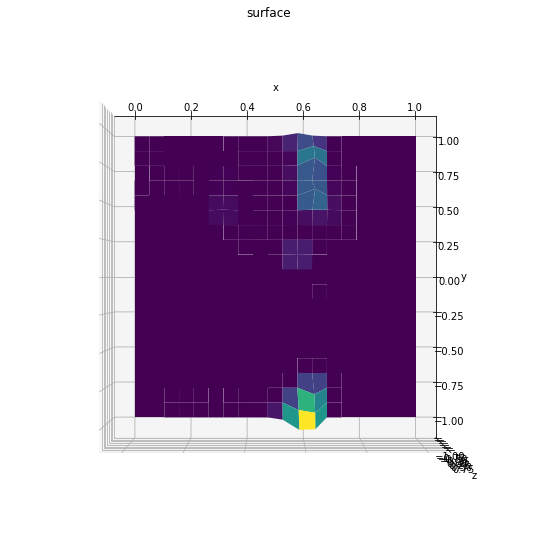

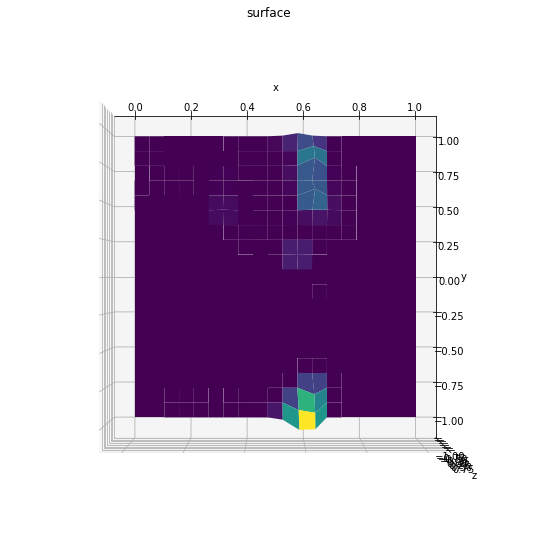

In [15]:
reward_net.visualize_net(agent_net, Npoints=20)

In [10]:
torch.save(agent_net.state_dict(), 'Results/C_origin/C_pointspace_policy_net_origin.mod')
torch.save(reward_net.state_dict(), 'Results/C_origin/C_pointspace_reward_net_origin.mod')